In [1]:
import os
import sys

In [2]:
import pandas as pd
from scipy import stats
from sklearn.neighbors import NearestNeighbors
import numpy as np

In [3]:
from importlib import reload
import time
from tqdm import tqdm
from functools import reduce
from itertools import islice

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display, HTML

In [5]:
from enviserv.dictan import DictAnalyzer # анализ словарей
import pandserv as pds # форматирование небольших пандас ДФ

In [6]:
from sparkserv import SparkApp, Cols
# в SparkApp упакованы функции создания спарк приложения 
# с определением IP мастер-ноды и с подключением к кластеру

# Col - класс для формирования коротких псевдонимов имен столбцов
# при этом исходные имена полей не меняются

In [7]:
import pyspark.sql.functions as f
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, IntegerType, LongType
from pyspark.sql.window import Window
from pyspark.sql import Row

In [8]:
# гео библиотеки
import geopandas as gpd
from shapely import wkt
from shapely.geometry import Point

### Создание сессии, загрузка данных

In [9]:
spark_app = SparkApp(my_logger_create_level = 'INFO')

INFO:spark_app:spark_master_ip: 172.18.0.2
INFO:spark_app:pyspark version: 3.4.1
INFO:spark_app:starting building spark app object: pyspark-taxi-forecasting
INFO:spark_app:Spark app object built as: <pyspark.sql.session.SparkSession object at 0x7ffb373f9150>
INFO:spark_app:==================================================================
INFO:spark_app:Spark object can be accessed as the SparkApp_object.spark property
INFO:spark_app:==================================================================


In [10]:
spark_master_ip = spark_app.get_spark_master_ip()
# print(spark_master_ip)

INFO:spark_app:spark_master_ip: 172.18.0.2


In [11]:
# spark = spark_app.build_spark_app(spark_master_ip=spark_master_ip)
# spark = spark_app.spark

Для корректного завершения спарк-сессии (например, для переключения между ноутбуками) следует останавливать сессию полностью. Для этого использую метод .stop_spark_app() класса SparkApp

In [12]:
# spark_app.stop_spark_app()

In [13]:
print(spark_app.spark)

In [14]:
spark_app.build_spark_app()

INFO:spark_app:pyspark version: 3.4.1
INFO:spark_app:starting building spark app object: pyspark-taxi-forecasting
INFO:spark_app:Spark app object built as: <pyspark.sql.session.SparkSession object at 0x7ffb373f9150>
INFO:spark_app:==================================================================
INFO:spark_app:Spark object can be accessed as the SparkApp_object.spark property
INFO:spark_app:==================================================================


In [15]:
spark = spark_app.spark

Проверка работы спарк-объекта на кластере. Если все в порядке, то нижеследующий код должен выполниться ыстро и отобразить тестовый ДФ.  
```yaml
+------------+-----------+
|student_name|student_age|
+------------+-----------+
|       Alice|         10|
|         Bob|         20|
+------------+-----------+
```

Если исходные образы кластера собраны с ошибкой, возможно "зависание" работы этого простого тестового кода.

In [16]:
data = [("Alice", 10), ("Bob", 20)]
columns = ["name", "age"]
df = spark.createDataFrame(data, columns)

# Присвоение псевдонимов столбцам
df_with_alias = df.select(df["name"].alias("student_name"), df["age"].alias("student_age"))
df_with_alias.show()
del df

+------------+-----------+
|student_name|student_age|
+------------+-----------+
|       Alice|         10|
|         Bob|         20|
+------------+-----------+



Загрузим данные. В интерфейсе Докера должно отображаться увеличение загрузки по всем воркерам (почти до 100%). Также можно увидеть рост загрузки на ядрах-потоках процессора, выделенных под кластер.

In [17]:
%%time
taxi = spark.read.load('/work/data/Taxi_Trips_-_2022.csv', 
                       format='csv', header='true', inferSchema='true')

CPU times: user 14.2 ms, sys: 1.27 ms, total: 15.5 ms
Wall time: 43.8 s


Для работы с геоточками (координатами и кодами районов) используются данные https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Boundaries-Census-Tracts-2010/5jrd-6zik

Загрузим ДФ `tracts` и создадим `tract_geo`, который будет использован далее для заполнение пропусков значений геоточек датафрейма `taxi`

In [18]:
%%time
tracts = spark.read.load('/work/data/CensusTractsTIGER2010.csv', 
                       format='csv', header='true', inferSchema='true')

CPU times: user 2.74 ms, sys: 0 ns, total: 2.74 ms
Wall time: 702 ms


In [19]:
tracts.printSchema()

root
 |-- the_geom: string (nullable = true)
 |-- STATEFP10: integer (nullable = true)
 |-- COUNTYFP10: integer (nullable = true)
 |-- TRACTCE10: integer (nullable = true)
 |-- GEOID10: long (nullable = true)
 |-- NAME10: double (nullable = true)
 |-- NAMELSAD10: string (nullable = true)
 |-- COMMAREA: integer (nullable = true)
 |-- COMMAREA_N: integer (nullable = true)
 |-- NOTES: string (nullable = true)



In [20]:
tracts.show(1)

+--------------------+---------+----------+---------+-----------+------+-----------------+--------+----------+-----+
|            the_geom|STATEFP10|COUNTYFP10|TRACTCE10|    GEOID10|NAME10|       NAMELSAD10|COMMAREA|COMMAREA_N|NOTES|
+--------------------+---------+----------+---------+-----------+------+-----------------+--------+----------+-----+
|MULTIPOLYGON (((-...|       17|        31|   842400|17031842400|8424.0|Census Tract 8424|      44|        44| null|
+--------------------+---------+----------+---------+-----------+------+-----------------+--------+----------+-----+
only showing top 1 row



In [21]:
tracts.take(1)[0]['the_geom'][:200]

'MULTIPOLYGON (((-87.62404799998049 41.73021699998396, -87.62404800002855 41.7302030000071, -87.6240480000349 41.730184000028295, -87.62404699998376 41.730137999986944, -87.62404600000936 41.7301209999'

Поле the_geom содержит данные в виде `'MULTIPOLYGON (((-87.62404799998049 41.73021699998396, -87.62404800002855 41.7302030000071, -87.6240480000349 41.730184000028295, -87.62404699998376 41.730137999986944,...)))'`, которые представляют собой строки с координатами в формате WKT (Well-Known Text). Чтобы преобразовать их в геометрические объекты, нужно использовать библиотеку `Shapely` для работы с WKT.  
Загрузим эти данные, рассчитаем координаты цетроидов и преобразуем полученную таблицу в ДФ Спарк.

In [22]:
# Чтение CSV файла с помощью pandas
tracts_df = pd.read_csv('/work/data/CensusTractsTIGER2010.csv')

# Преобразование строк WKT в геометрические объекты
tracts_df['geometry'] = tracts_df['the_geom'].apply(wkt.loads)

# Создание GeoDataFrame
gdf = gpd.GeoDataFrame(tracts_df, geometry='geometry')

# Вычисление центроидов
gdf['centroid'] = gdf['geometry'].centroid

# Извлечение координат центроидов
gdf['centroid_x'] = gdf['centroid'].apply(lambda point: point.x)
gdf['centroid_y'] = gdf['centroid'].apply(lambda point: point.y)

# Создание нового DataFrame с нужными столбцами
centroids_df = gdf[['GEOID10', 'centroid_y', 'centroid_x']].rename(columns={
    'GEOID10': 'census_tract',
    'centroid_y': 'latitude',
    'centroid_x': 'longitude'
})

# Определение схемы для Spark DataFrame
schema = StructType([
    StructField('census_tract', StringType(), True),
    StructField('latitude', DoubleType(), True),
    StructField('longitude', DoubleType(), True)
])

# Преобразование pandas DataFrame в Spark DataFrame
tract_geo = spark.createDataFrame(centroids_df, schema)

# Показать первые несколько строк Spark DataFrame
tract_geo.show(5)
print(tract_geo.count())

+------------+------------------+------------------+
|census_tract|          latitude|         longitude|
+------------+------------------+------------------+
| 17031842400| 41.74247518248426|-87.63004035576937|
| 17031840300| 41.83209440350829| -87.6818820146571|
| 17031841100|  41.8510058477232|-87.63509777614824|
| 17031841200|41.855561874827515|-87.68334196400778|
| 17031839000|41.871044193578264|-87.63140452575338|
+------------+------------------+------------------+
only showing top 5 rows

801


In [23]:
# tracts.take(1)[0]["the_geom"]

In [24]:
# taxi_rdd = spark.sparkContext.textFile('/work/data/Taxi_Trips_-_2022.csv')
# taxi_rdd.take(2)

In [25]:
# taxi.printSchema()

In [26]:
# создадим объект для представления имен полей
ct = Cols(taxi)
ct.get_aliases()

{'trip_i': 'Trip ID',
 'taxi_i': 'Taxi ID',
 'trip_st': 'Trip Start Timestamp',
 'trip_et': 'Trip End Timestamp',
 'trip_s': 'Trip Seconds',
 'trip_m': 'Trip Miles',
 'pickup_ct': 'Pickup Census Tract',
 'dropoff_ct': 'Dropoff Census Tract',
 'pickup_ca': 'Pickup Community Area',
 'dropoff_ca': 'Dropoff Community Area',
 'fare': 'Fare',
 'tips': 'Tips',
 'tolls': 'Tolls',
 'extras': 'Extras',
 'trip_t': 'Trip Total',
 'payment_t': 'Payment Type',
 'company': 'Company',
 'pickup_cl': 'Pickup Centroid Latitude',
 'pickup_clon': 'Pickup Centroid Longitude',
 'pickup_cloc': 'Pickup Centroid Location',
 'dropoff_cl': 'Dropoff Centroid Latitude',
 'dropoff_clon': 'Dropoff Centroid Longitude',
 'dropoff_cloc': 'Dropoff Centroid  Location'}

Загрузим ранее сохраненный файл с описанием полей ДФ такси

In [27]:
pd.set_option('display.max_colwidth', None)

table_descr = pd.read_csv('/work/data/table_descr.csv',sep=';',index_col='Column Name')
display(table_descr)

pd.reset_option('display.max_colwidth')  # Сброс максимальной ширины столбцов к значению по умолчанию

,Description,Type,Описание,Тип
Column Name,,,,
Trip ID,A unique identifier for the trip.,Plain Text,Уникальный идентификатор поездки,Обычный текст
Taxi ID,A unique identifier for the taxi.,Plain Text,Уникальный идентификатор такси,Обычный текст
Trip Start Timestamp,When the trip started rounded to the nearest 15 minutes.,Date & Time,Время начала поездки округленное до ближайших 15 минут,Дата и время
Trip End Timestamp,When the trip ended rounded to the nearest 15 minutes.,Date & Time,Время окончания поездки округленное до ближайших 15 минут,Дата и время
Trip Seconds,Time of the trip in seconds.,Number,Продолжительность поездки в секундах,Число
Trip Miles,Distance of the trip in miles.,Number,Расстояние поездки в милях,Число
Pickup Census Tract,The Census Tract where the trip began. For privacy this Census Tract is not shown for some trips. This column often will be blank for locations outside Chicago.,Plain Text,Код района по переписи населения где началась поездка. В целях конфиденциальности этот код не отображается для некоторых поездок. Это поле часто остается пустым для мест за пределами Чикаго.,Обычный текст
Dropoff Census Tract,The Census Tract where the trip ended. For privacy this Census Tract is not shown for some trips. This column often will be blank for locations outside Chicago.,Plain Text,Код района по переписи населения где завершилась поездка. В целях конфиденциальности этот код не отображается для некоторых поездок. Это поле часто остается пустым для мест за пределами Чикаго.,Обычный текст
Pickup Community Area,The Community Area where the trip began. This column will be blank for locations outside Chicago.,Number,Номер коммунальной области где началась поездка. Это поле остается пустым для мест за пределами Чикаго.,Число


### Описание полей "Census Tract" и "Community Area"

Поля "Census Tract" и "Community Area" представляют собой два различных уровня административных единиц:

**Census Tract:**  
Это статистические единицы, используемые в переписи населения в США, проводимой каждые 10 лет.
Census Tract обычно представляют собой географические области, населенные от 1 200 до 8 000 человек.
Они предназначены для обеспечения стандартизированных данных для анализа населения, доходов, расового и этнического состава и других социально-экономических параметров.

Далее для краткости буду называть данную адм.единицу - **Район** (хотя правильней было бы "квартал", но этот термин будет путаться с временным окном)

**Community Area:**  
Это административные районы в городе Чикаго, разработанные городским правительством.
Community Areas используются для организации и управления городскими службами и ресурсами.
Обычно Community Areas выступают в качестве единиц анализа для изучения социальных и экономических показателей, таких как уровень преступности, доступность образования и здравоохранения и др.

Далее для краткости буду называть данную адм.единицу - **Округ**

Community Area представляют собой административные районы, охватывающие большие части города, в то время как Census Tract более мелкие географические области, которые могут быть распределены по всему Community Area. Таким образом, Community Area охватывает несколько Census Tract и представляет собой более крупную административную единицу.

В идеальной ситуации каждый Census Tract должен быть частью только одной Community Area, чтобы избежать перекрытий и дублирования данных. Однако в реальности могут быть исключения из-за изменений границ административных районов или других факторов.

In [28]:
# %%time
# код ячейки закомментирован, т.к. описание данных
# уже сохранено во внешнейм файле
# но при необходимости пересчитать статистики
# код надо раскомментировать

# describe_result = taxi.describe().toPandas()

# time cost for i5 (7g), 4 workers (x) 2gb RAM 
# CPU times: user 352 ms, sys: 32.2 ms, total: 384 ms
# Wall time: 2min 7s

In [29]:
# output_file_path = '/work/data/2022_describe.csv'
# describe_result.to_csv(output_file_path, index=False) #transpose().

Импортируем сохраненную таблицу-описание данных `.describe()`

In [30]:
dr = pd.read_csv('/work/data/2022_describe.csv',sep=',',index_col='summary')

In [31]:
drf = dr.copy()
#  отформатируем таблицу описания
pds.get_df_formated(drf, '`',2, 10)

In [32]:
drf.transpose()

summary,count,mean,stddev,min,max
Trip ID,6`382`425,nan,nan,000000bb18,ffffff1aae
Taxi ID,6`382`425,nan,nan,0041f8f0c9,fff84aa08a
Trip Start Timestamp,6`382`425,nan,nan,01/01/2022,12/31/2022
Trip End Timestamp,6`382`213,nan,nan,01/01/2022,12/31/2022
Trip Seconds,6`380`960,1`198.21,1`895.66,0,86`341
Trip Miles,6`382`369,6.19,8.00,0,2`967.54
Pickup Census Tract,2`623`831,17`031`468`160.38,368`945.90,17`031`010`100,17`031`980`100
Dropoff Census Tract,2`675`331,17`031`411`846.86,345`773.49,17`031`010`100,17`031`980`100
Pickup Community Area,5`868`572,32.35,25.20,1,77
Dropoff Community Area,5`748`741,25.84,20.93,1,77


In [33]:
# val = int(dr.transpose()['count'].astype(float).max())
# print(pds.gvf(val))

In [34]:
%%time
row_count = taxi.count()

# time cost i5 (7g), 4 workers (x) 2gb RAM
# CPU times: user 5.85 ms, sys: 871 µs, total: 6.72 ms
# Wall time: 11.8 s

CPU times: user 2.97 ms, sys: 10.7 ms, total: 13.7 ms
Wall time: 13.9 s


In [35]:
print(pds.gvf(row_count))

6'382'425


### Оценим количество пропусков

In [36]:
drt = dr.transpose()
drt['count'] = drt['count'].astype(int)
drt['not_null_ratio']=drt['count']/row_count

drt = drt[['count','not_null_ratio']]

# отображение отформатированных данных
pds.get_df_formated(drt,'`',4, 10)

display(drt)

print('============================================')
print('=== columns count ==================',int(len(drt)),'====')
print('============================================')

summary,count,not_null_ratio
Trip ID,6`382`425,1
Taxi ID,6`382`425,1
Trip Start Timestamp,6`382`425,1
Trip End Timestamp,6`382`213,1.0000
Trip Seconds,6`380`960,0.9998
Trip Miles,6`382`369,1.0000
Pickup Census Tract,2`623`831,0.4111
Dropoff Census Tract,2`675`331,0.4192
Pickup Community Area,5`868`572,0.9195
Dropoff Community Area,5`748`741,0.9007


=== columns count ================== 23 ====


Видим, что  
- 7 полей не содержат пропусков (not_null_ratio = 1), в т.ч 2 почти их не имеют (1.0000);
- 8 полей заполнены более чем на 99%;
- `Pickup Census Tract`, `Dropoff Census Tract` заполнены менее, чем на 50%;
- поля с геоданными (latitude, longitude) заполнены более, чем на 90%
- поля со значениями округов (`Community Area`) заполнены более, чем на 90%

Поскольку прогноз строится для районов (tract), необходимо максимально избавиться от пропусков в цензус трактах. Попробуем связать поля геоданных (широты, долготы) и кодов районов, чтобы использовать данные самого датасета для заполнения пропусков.

### Ключи-агрегаторы

В качестве ключа предполагается использовать кортеж-четверку (код квартала, широта, долгота, код округа)

Посмотрим состав четверок. Сокращение префиксов имен датафреймов:  
ctp - pickup census tract  
ctd - dropoff census tract

In [37]:
# ctp - pickup census tract
ctp = taxi.groupBy(ct.pickup_ct).count().orderBy("count", ascending=False).cache()
ctp.show(5)
ctp_count = ctp.filter(ctp[ct.pickup_ct].isNotNull()).count()
print('============================================')
print('pickup ct count:',ctp_count)

+-------------------+-------+
|Pickup Census Tract|  count|
+-------------------+-------+
|               null|3758594|
|        17031980000| 519802|
|        17031320100| 304178|
|        17031839100| 284131|
|        17031281900| 188178|
+-------------------+-------+
only showing top 5 rows

pickup ct count: 665


In [38]:
# ctd - dropoff census tract
ctd = taxi.groupBy(ct.dropoff_ct).count().orderBy("count", ascending=False).cache()
ctd.show(5)
ctd_count = ctd.filter(ctd[ct.dropoff_ct].isNotNull()).count()
print('============================================')
print('dropoff ct count:',ctd_count)

+--------------------+-------+
|Dropoff Census Tract|  count|
+--------------------+-------+
|                null|3707094|
|         17031839100| 328855|
|         17031320100| 277879|
|         17031980000| 243652|
|         17031081500| 160251|
+--------------------+-------+
only showing top 5 rows

dropoff ct count: 811


Районов высадки значительно больше

In [39]:
only_ctd = ctd.filter(ctd[ct.dropoff_ct].isNotNull()).\
join(ctp.filter(ctp[ct.pickup_ct].isNotNull()),\
     ctd[ct.dropoff_ct]==ctp[ct.pickup_ct],'left_anti').cache()
only_ctd_count = only_ctd.count()
print("количество районов высадки, которых нет в мн-ве р-нов посадки:", only_ctd_count)

количество районов высадки, которых нет в мн-ве р-нов посадки: 180


In [40]:
# количество районов посадки, которых нет в мн-ве р-нов высадки
only_ctp = ctp.filter(ctp[ct.pickup_ct].isNotNull()).\
join(ctd.filter(ctd[ct.dropoff_ct].isNotNull()),\
     ctd[ct.dropoff_ct]==ctp[ct.pickup_ct],'left_anti').cache()
only_ctp_count = only_ctp.count()
print("количество районов посадки, которых нет в мн-ве р-нов высадки:", only_ctp_count)

количество районов посадки, которых нет в мн-ве р-нов высадки: 34


В значительной части множества значений районов высадки и посадки не пересекаются

Посмотрим состав районов в связке с их координатами-геоточками (кортежи-четверки)

In [41]:
# ДФ по районам посадки, содержащий четверки: код р-на, широта, долгота
ctp_geo = taxi.groupBy(
    ct.pickup_ct,ct.pickup_cl,ct.pickup_clon,ct.pickup_ca
).count().orderBy("count", ascending=False)
ctp_geo.cache()

DataFrame[Pickup Census Tract: bigint, Pickup Centroid Latitude: double, Pickup Centroid Longitude: double, Pickup Community Area: int, count: bigint]

In [42]:
ctp_geo.show(5)
print(ctp_geo.count())

+-------------------+------------------------+-------------------------+---------------------+------+
|Pickup Census Tract|Pickup Centroid Latitude|Pickup Centroid Longitude|Pickup Community Area| count|
+-------------------+------------------------+-------------------------+---------------------+------+
|               null|            41.899602111|            -87.633308037|                    8|673556|
|        17031980000|             41.97907082|            -87.903039661|                   76|519802|
|               null|                    null|                     null|                 null|510734|
|               null|            41.980264315|            -87.913624596|                   76|469878|
|               null|            41.878865584|            -87.625192142|                   32|308122|
+-------------------+------------------------+-------------------------+---------------------+------+
only showing top 5 rows

743


In [43]:
# Посмотрим повторяющиеся геоточки
ctp_geo_dupl = ctp_geo.groupBy(ct.pickup_cl,ct.pickup_clon).count().filter(f.col('count') > 1).cache()
ctp_geo_dupl.show()

+------------------------+-------------------------+-----+
|Pickup Centroid Latitude|Pickup Centroid Longitude|count|
+------------------------+-------------------------+-----+
|                    null|                     null|  127|
|            41.728182061|            -87.596475596|    2|
+------------------------+-------------------------+-----+



Видим значительное количество пустых геоточек (координат). Отберем отдельно те из них, которые имеют непустое значение для кода района.

In [44]:
# Посмотрим районы с пустыми значениями для широты-долготы и непустыми значениями для районов
ctp_geo_nulls = ctp_geo.filter(ctp_geo[ct.pickup_cl].isNull() \
               & ctp_geo[ct.pickup_clon].isNull()\
               & ctp_geo[ct.pickup_ct].isNotNull())
ctp_geo_nulls.show(5)

+-------------------+------------------------+-------------------------+---------------------+-----+
|Pickup Census Tract|Pickup Centroid Latitude|Pickup Centroid Longitude|Pickup Community Area|count|
+-------------------+------------------------+-------------------------+---------------------+-----+
|        17031804603|                    null|                     null|                 null|   42|
|        17031804701|                    null|                     null|                 null|   36|
|        17031801500|                    null|                     null|                 null|   34|
|        17031808200|                    null|                     null|                 null|   31|
|        17031804201|                    null|                     null|                 null|   29|
+-------------------+------------------------+-------------------------+---------------------+-----+
only showing top 5 rows



Также посмотрим коды р-на, для повторяющихся непустых геоточек

In [45]:
# посмотрим коды р-на, для повторяющихся непустых геоточек
# Фильтрация и присвоение алиаса "a" для ctp_geo_dupl
ctp_geo_dupl_filtered = ctp_geo_dupl.filter(
    ctp_geo_dupl[ct.pickup_cl].isNotNull() & ctp_geo_dupl[ct.pickup_clon].isNotNull()
).alias("a")

# Присвоение алиаса "b" для ctp_geo
ctp_geo_alias = ctp_geo.alias("b")

# Выполнение join с использованием алиасов и квалифицированных имен столбцов
result = ctp_geo_dupl_filtered.join(
    ctp_geo_alias,
    (f.col("a." + ct.pickup_cl) == f.col("b." + ct.pickup_cl)) & 
    (f.col("a." + ct.pickup_clon) == f.col("b." + ct.pickup_clon))
).select(
    f.col("b." + ct.pickup_ct), 
    f.col("b." + ct.pickup_cl), 
    f.col("b." + ct.pickup_clon)
)

result.show()

+-------------------+------------------------+-------------------------+
|Pickup Census Tract|Pickup Centroid Latitude|Pickup Centroid Longitude|
+-------------------+------------------------+-------------------------+
|               null|            41.728182061|            -87.596475596|
|        17031470100|            41.728182061|            -87.596475596|
+-------------------+------------------------+-------------------------+



Тот же запрос с использованием SQL. Код выглядит более компактным

In [46]:
ctp_geo_dupl.createOrReplaceTempView("ctp_geo_dupl")
ctp_geo.createOrReplaceTempView("ctp_geo")

sql_query = f"""
SELECT b.`{ct.pickup_ct}`, b.`{ct.pickup_cl}`, b.`{ct.pickup_clon}`
FROM ctp_geo_dupl a
JOIN ctp_geo b
ON a.`{ct.pickup_cl}` = b.`{ct.pickup_cl}` 
AND a.`{ct.pickup_clon}` = b.`{ct.pickup_clon}`
WHERE a.`{ct.pickup_cl}` IS NOT NULL 
AND a.`{ct.pickup_clon}` IS NOT NULL
"""
result = spark.sql(sql_query)
result.show()

+-------------------+------------------------+-------------------------+
|Pickup Census Tract|Pickup Centroid Latitude|Pickup Centroid Longitude|
+-------------------+------------------------+-------------------------+
|               null|            41.728182061|            -87.596475596|
|        17031470100|            41.728182061|            -87.596475596|
+-------------------+------------------------+-------------------------+



Завернем код с отбором пустых/непустых геоточек в функцию, для применения трансформаций также для районов высадки

In [47]:
def get_geo_points(df, ct, lat, lon, area):
    # Создание DataFrame по районам (посадки или высадки),
    # содержащий тройки: код р-на, широта, долгота
    geo_df = df.groupBy(
        ct, lat, lon, area
    ).count().orderBy("count", ascending=False)
    geo_df

    # Поиск повторяющихся геоточек
    geo_dupl = geo_df.groupBy(lat, lon)\
    .count().filter(f.col('count') > 1)

    # Отбор пустых геоточек, которые имеют
    # непустое значение для кода района
    geo_nulls_ct_notnull = geo_df.filter(
        geo_df[lat].isNull() & 
        geo_df[lon].isNull() & 
        geo_df[ct].isNotNull()
    )
    # непустые геоточки и пустые районы
    geo_notnull_ct_null = geo_df.filter(
        geo_df[lat].isNotNull() & 
        geo_df[lon].isNotNull() &
        geo_df[ct].isNull()
    )
    
    # Фильтрация и присвоение алиаса "a" для geo_dupl
    geo_dupl_filtered = geo_dupl.filter(
        geo_dupl[lat].isNotNull() & 
        geo_dupl[lon].isNotNull()
    ).alias("a")

    # Присвоение алиаса "b" для geo_df
    geo_alias = geo_df.alias("b")

    # Выполнение join с использованием алиасов
    # и квалифицированных имен столбцов
    geo_notnull_dupl = geo_dupl_filtered.join(
        geo_alias,
        (f.col(f"a.{lat}") == f.col(f"b.{lat}")) & 
        (f.col(f"a.{lon}") == f.col(f"b.{lon}"))
    ).select(
        f.col(f"b.{ct}"), 
        f.col(f"b.{lat}"), 
        f.col(f"b.{lon}")
    )

    return geo_df, geo_nulls_ct_notnull, geo_notnull_ct_null, geo_notnull_dupl

Получим датафреймы геоточек

In [48]:
ctp_geo, ctp_geo_nulls_ct_notnull, ctp_geo_notnull_ct_null, ctp_geo_notnull_dupl = \
        get_geo_points(taxi, ct.pickup_ct, ct.pickup_cl, ct.pickup_clon, ct.pickup_ca)

In [49]:
ctd_geo, ctd_geo_nulls_ct_notnull, ctd_geo_notnull_ct_null, ctd_geo_notnull_dupl = \
        get_geo_points(taxi, ct.dropoff_ct, ct.dropoff_cl, ct.dropoff_clon, ct.dropoff_ca)

In [50]:
ctp_geo.cache()
ctp_geo_nulls_ct_notnull.cache()
ctp_geo_notnull_ct_null.cache()
ctp_geo_notnull_dupl.cache()

DataFrame[Pickup Census Tract: bigint, Pickup Centroid Latitude: double, Pickup Centroid Longitude: double]

In [51]:
ctd_geo.cache()
ctd_geo_nulls_ct_notnull.cache()
ctd_geo_notnull_ct_null.cache()
ctd_geo_notnull_dupl.cache()

DataFrame[Dropoff Census Tract: bigint, Dropoff Centroid Latitude: double, Dropoff Centroid Longitude: double]

Проверим на всякий случай- есть ли записи только с одним пустым значением в паре (широта, долгота)

In [52]:
ctd_geo.filter((ctd_geo[ct.dropoff_cl].isNull() \
               & ctd_geo[ct.dropoff_clon].isNotNull())\
               |(ctd_geo[ct.dropoff_cl].isNotNull() \
               & ctd_geo[ct.dropoff_clon].isNull())).count()

0

In [53]:
ctp_geo.filter((ctp_geo[ct.pickup_cl].isNull() \
               & ctp_geo[ct.pickup_clon].isNotNull())\
               |(ctp_geo[ct.pickup_cl].isNotNull() \
               & ctp_geo[ct.pickup_clon].isNull())).count()

0

Таких записей для точек посадки и высадки нет. Т.е. доп обработка не требуется, можно оперировать парами (широта, долгота)

Посмотрим коды р-нов, для повторяющихся непустых геоточек

In [54]:
ctp_geo_notnull_dupl.show()
ctd_geo_notnull_dupl.show()

+-------------------+------------------------+-------------------------+
|Pickup Census Tract|Pickup Centroid Latitude|Pickup Centroid Longitude|
+-------------------+------------------------+-------------------------+
|               null|            41.728182061|            -87.596475596|
|        17031470100|            41.728182061|            -87.596475596|
+-------------------+------------------------+-------------------------+

+--------------------+-------------------------+--------------------------+
|Dropoff Census Tract|Dropoff Centroid Latitude|Dropoff Centroid Longitude|
+--------------------+-------------------------+--------------------------+
|                null|             41.728182061|             -87.596475596|
|         17031470100|             41.728182061|             -87.596475596|
+--------------------+-------------------------+--------------------------+



Видим, что такая геоточка одна `(41.728182061|-87.596475596)`, которая соответствует только одному району. И пустые значения района для такой точки могут быть заменены на `17031470100`

Также можно сделать вывод, что другие пропуски значений кодов районов нельзя заполнить, связав их с непустыми геоточками.

Получим общий ДФ (посадки и высадки) для непустых уникальных троек (район, широта, долгота)

In [55]:
def get_geo_notnull(df, cols_aliases: dict, empty_cols: list = None):
    if empty_cols is None: empty_cols = []
    selected_cols = [f.col(key).alias(cols_aliases[key]) for key in cols_aliases]
    filter_conditions = [
        f.col(alias).isNull() if alias in empty_cols else f.col(alias).isNotNull()
        for alias in cols_aliases.values()
    ]
    combined_filter = reduce(lambda x, y: x & y, filter_conditions)
    geo_notnull = df.select(*selected_cols).filter(combined_filter).distinct()
    
    return geo_notnull

In [56]:
ctp_aliases = {
    ct.pickup_ct: "census_tract",
    ct.pickup_cl: "latitude",
    ct.pickup_clon: "longitude",
    # ct.pickup_ca: "area"
}
ctp_geo_notnull = get_geo_notnull(ctp_geo, ctp_aliases)

ctd_aliases = {
    ct.dropoff_ct: "census_tract",
    ct.dropoff_cl: "latitude",
    ct.dropoff_clon: "longitude",
    # ct.dropoff_ca: "area"
}
ctd_geo_notnull = get_geo_notnull(ctd_geo, ctd_aliases)

ct_geo_notnull_union = ctd_geo_notnull.union(ctp_geo_notnull).distinct()
ct_geo_notnull_union.show(5)
ct_geo_notnull_union.cache()
ct_geo_notnull_union.count()

+------------+------------+-------------+
|census_tract|    latitude|    longitude|
+------------+------------+-------------+
| 17031250300|41.912836784|-87.760884371|
| 17031040402|41.972562538|-87.678845966|
| 17031351000|41.834673598|-87.610834737|
| 17031550200|41.651921576|-87.564929171|
| 17031490400|41.723821251|-87.611845985|
+------------+------------+-------------+
only showing top 5 rows



613

In [57]:
ctp_aliases = {
    # ct.pickup_ct: "census_tract",
    ct.pickup_cl: "latitude",
    ct.pickup_clon: "longitude",
    ct.pickup_ca: "area"
}
ctp_geo_notnull_area = get_geo_notnull(ctp_geo, ctp_aliases)

ctd_aliases = {
    # ct.dropoff_ct: "census_tract",
    ct.dropoff_cl: "latitude",
    ct.dropoff_clon: "longitude",
    ct.dropoff_ca: "area"
}
ctd_geo_notnull_area = get_geo_notnull(ctd_geo, ctd_aliases)

ct_geo_notnull_area_union = ctd_geo_notnull_area.union(ctp_geo_notnull_area).distinct()
ct_geo_notnull_area_union.show(5)
ct_geo_notnull_area_union.cache()
ct_geo_notnull_area_union.count()

+------------+-------------+----+
|    latitude|    longitude|area|
+------------+-------------+----+
|41.814440937|-87.730733454|  57|
| 41.87101588|-87.631406525|  32|
| 41.84201118|-87.622036461|  35|
|41.870268722|-87.684913926|  28|
|41.810879008|-87.726363325|  57|
+------------+-------------+----+
only showing top 5 rows



688

Посмотрим - возможно ли использовать значения непустых троек для заполнения:
- пустых значений геоточек (связывая датафреймы по коду района)
- пустых значений кодов района (связывая датафреймы по геоточкам)

In [58]:
# пустые значения геоточек и непустые- районов
# посадки
ctp_geo_nulls_ct_notnull_in_union = ct_geo_notnull_union.alias("a").join(
    ctp_geo_nulls_ct_notnull.alias("b"),
    (f.col("a.census_tract") == f.col(f"b.{ct.pickup_ct}"))
).select(
    f.col("a.census_tract"), 
    f.col("a.latitude"), 
    f.col("a.longitude")
)
# ctp_geo_nulls_ct_notnull_in_union.show(5)
print(ctp_geo_nulls_ct_notnull_in_union.count())
ctp_geo_nulls_ct_notnull_in_union.cache()

0


DataFrame[census_tract: bigint, latitude: double, longitude: double]

In [59]:
# пустые значения геоточек и непустые- районов
# высадки
ctd_geo_nulls_ct_notnull_in_union = ct_geo_notnull_union.alias("a").join(
    ctd_geo_nulls_ct_notnull.alias("b"),
    (f.col("a.census_tract") == f.col(f"b.{ct.dropoff_ct}"))
).select(
    f.col("a.census_tract"), 
    f.col("a.latitude"), 
    f.col("a.longitude")
)
# ctd_geo_nulls_ct_notnull_in_union.show(5)
print(ctd_geo_nulls_ct_notnull_in_union.count())
ctd_geo_nulls_ct_notnull_in_union.cache()

0


DataFrame[census_tract: bigint, latitude: double, longitude: double]

Т.е. для пустых геоточек (координат) невозможно получить значения кодов районов из непустых троек

In [60]:
# непустые значения геоточек и пустые- районов
# высадки

ctd_geo_notnull_ct_nulls_in_union = ct_geo_notnull_union.alias("a").join(
    ctd_geo_notnull_ct_null.alias("b"),
    (f.col("a.latitude") == f.col(f"b.{ct.dropoff_cl}")) &
    (f.col("a.longitude") == f.col(f"b.{ct.dropoff_clon}"))
).select(
    f.col("a.census_tract"), 
    f.col("a.latitude"), 
    f.col("a.longitude")
)
ctd_geo_notnull_ct_nulls_in_union.show(5)
ctd_geo_notnull_ct_nulls_in_union.count()

+------------+------------+-------------+
|census_tract|    latitude|    longitude|
+------------+------------+-------------+
| 17031470100|41.728182061|-87.596475596|
+------------+------------+-------------+



1

In [61]:
# непустые значения геоточек и пустые- районов
# посадки

ctp_geo_notnull_ct_nulls_in_union = ct_geo_notnull_union.alias("a").join(
    ctp_geo_notnull_ct_null.alias("b"),
    (f.col("a.latitude") == f.col(f"b.{ct.pickup_cl}")) &
    (f.col("a.longitude") == f.col(f"b.{ct.pickup_clon}"))
).select(
    f.col("a.census_tract"), 
    f.col("a.latitude"), 
    f.col("a.longitude")
)
ctp_geo_notnull_ct_nulls_in_union.show(5)
ctp_geo_notnull_ct_nulls_in_union.count()

+------------+------------+-------------+
|census_tract|    latitude|    longitude|
+------------+------------+-------------+
| 17031470100|41.728182061|-87.596475596|
+------------+------------+-------------+



1

Это мы уже видели выше.

Осталось посмотреть наличие непустых округов вместе с пустыми тройками (район, шир, долгота)

In [62]:
# список полей, которые должны быть пустыми в фильтре
empty_cols = ["census_tract","latitude","longitude"]

ctp_aliases = {
    ct.pickup_ct: "census_tract",
    ct.pickup_cl: "latitude",
    ct.pickup_clon: "longitude",
    ct.pickup_ca: "area"
}
ctp_geo_only_area = get_geo_notnull(ctp_geo, ctp_aliases, empty_cols=empty_cols)

ctd_aliases = {
    ct.dropoff_ct: "census_tract",
    ct.dropoff_cl: "latitude",
    ct.dropoff_clon: "longitude",
    ct.dropoff_ca: "area"
}
ctd_geo_only_area = get_geo_notnull(ctd_geo, ctd_aliases, empty_cols=empty_cols)

print("Количество непустых округов посадки  вместе с пустыми тройками:",ctp_geo_only_area.count())
print("Количество непустых округов высадки  вместе с пустыми тройками:",ctd_geo_only_area.count())

Количество непустых округов посадки  вместе с пустыми тройками: 0
Количество непустых округов высадки  вместе с пустыми тройками: 0


Т.о. получить доп.информацию из данных по округам для заполнения пропусков в геоточках (кодах районов) не получается. Непустые значения округов всегда идут "в комплекте" с непустыми значениями троек (район, широта, долгота)

In [63]:
ctp_aliases["count"] = "count" # добавим в словарь псевдонимов поле "count"
selected_cols = [f.col(key).alias(ctp_aliases[key]) for key in ctp_aliases]
filter_conditions = [f.col(alias).isNull() for alias in ctp_aliases.values() if alias != "count"]
combined_filter = reduce(lambda x, y: x & y, filter_conditions)

ctp_all_keys_null = ctp_geo.select(selected_cols).filter(combined_filter)
ctp_all_keys_null.show()
ctp_all_keys_null_count = ctp_all_keys_null.take(1)[0]["count"]

print("Количество записей с пустыми полями по гео-ключам посадки (район, широта, долгота, округ):",
      pds.gvf(ctp_all_keys_null_count))
print(f"Доля таких записей в датасете: {(ctp_all_keys_null_count/row_count)*100:.2f}%")

+------------+--------+---------+----+------+
|census_tract|latitude|longitude|area| count|
+------------+--------+---------+----+------+
|        null|    null|     null|null|510734|
+------------+--------+---------+----+------+

Количество записей с пустыми полями по гео-ключам посадки (район, широта, долгота, округ): 510'734
Доля таких записей в датасете: 8.00%


In [64]:
ctd_aliases["count"] = "count" # добавим в словарь псевдонимов поле "count"
selected_cols = [f.col(key).alias(ctd_aliases[key]) for key in ctd_aliases]
filter_conditions = [f.col(alias).isNull() for alias in ctd_aliases.values() if alias != "count"]
combined_filter = reduce(lambda x, y: x & y, filter_conditions)

ctd_all_keys_null = ctd_geo.select(selected_cols).filter(combined_filter)
ctd_all_keys_null.show()
ctd_all_keys_null_count = ctd_all_keys_null.take(1)[0]["count"]

print("Количество записей с пустыми полями по гео-ключам высадки (район, широта, долгота, округ):",
      pds.gvf(ctd_all_keys_null_count))
print(f"Доля таких записей в датасете: {(ctd_all_keys_null_count/row_count)*100:.2f}%")

+------------+--------+---------+----+------+
|census_tract|latitude|longitude|area| count|
+------------+--------+---------+----+------+
|        null|    null|     null|null|590945|
+------------+--------+---------+----+------+

Количество записей с пустыми полями по гео-ключам высадки (район, широта, долгота, округ): 590'945
Доля таких записей в датасете: 9.26%


In [65]:
key_full_null_count = taxi.filter(
    f.col(ct.pickup_ct).isNull() &\
    f.col(ct.pickup_cl).isNull() &\
    f.col(ct.dropoff_ct).isNull() &\
    f.col(ct.dropoff_cl).isNull()
).count()
print("Количество записей с пустыми полями по гео-ключам высадки и высадки:",
      pds.gvf(key_full_null_count))
print(f"Доля таких записей в датасете: {(key_full_null_count/row_count)*100:.2f}%")

Количество записей с пустыми полями по гео-ключам высадки и высадки: 226'658
Доля таких записей в датасете: 3.55%


Исходя из проведенного анализа, заключил, что используя данные самого датасета taxi, явным образом возможно заполнить пропуски в полях 'census tract' только для записей с геоточкой `(41.728182061, -87.596475596)` значением `17031470100`. Посмотрим количество таких записей.

In [66]:
# Определим значение геоточки
latitude_value = 41.728182061
longitude_value = -87.596475596

# Подсчёт количества строк с заданной геоточкой и пустым значением тракта для pickup
ctp_geo_null_ct_count = ctp_geo.filter(
    (f.col("Pickup Centroid Latitude") == latitude_value) &
    (f.col("Pickup Centroid Longitude") == longitude_value) &
    f.col("Pickup Census Tract").isNull()
).take(1)[0]["count"]

# Подсчёт количества строк с заданной геоточкой и пустым значением тракта для dropoff
ctd_geo_null_ct_count = ctd_geo.filter(
    (f.col("Dropoff Centroid Latitude") == latitude_value) &
    (f.col("Dropoff Centroid Longitude") == longitude_value) &
    f.col("Dropoff Census Tract").isNull()
).take(1)[0]["count"]

# Выводим результаты
print("Количество строк с пустым значением тракта и геоточкой для pickup:", ctp_geo_null_ct_count)
print("Количество строк с пустым значением тракта и геоточкой для dropoff:", ctd_geo_null_ct_count)


Количество строк с пустым значением тракта и геоточкой для pickup: 1729
Количество строк с пустым значением тракта и геоточкой для dropoff: 1917


В масштабах датасета такое заполнение крайне незначительно снизит долю пропусков. Необходимо использовать дополнительные данные.

Воспользуемся отдельно загруженными (внешними по отношению к датасету taxi) данными по районам с вычисленными значениями координат цетроидов (геоточек). Свяжем датафреймы с данными по геоточкам (внешний и taxi) по коду района и посмотрим на разницу координат цетроидов.

In [67]:
# Константы для преобразования градусов в метры
LAT_TO_METERS = 111000  # 1 градус широты ~ 111 км
LON_TO_METERS = 78000  # 1 градус долготы ~ 78 км (на широте 45 градусов)

print("Сводные данные разницы координат центроидов для районов посадки")
# связываем районы посадки
ctp_bound = tract_geo.alias("a").join(
    ctp_geo\
    .filter(
        (f.col(ct.pickup_cl).isNotNull()) & 
        (f.col(ct.pickup_clon).isNotNull())
    ).alias("b"),
    (f.col("a.census_tract") == f.col(f"b.{ct.pickup_ct}")))\
.select(
    f.col("a.census_tract"),
    f.col("a.latitude").alias("geo_lat"),
    f.col("a.longitude").alias("geo_lon"),
    f.col("b." + ct.pickup_cl).alias("taxi_lat"),
    f.col("b." + ct.pickup_clon).alias("taxi_lon")
)\
.withColumn("lat_diff", f.abs(f.col("geo_lat") - f.col("taxi_lat")))\
.withColumn("lon_diff", f.abs(f.col("geo_lon") - f.col("taxi_lon")))\
.withColumn("lat_diff_m", f.col("lat_diff") * LAT_TO_METERS)\
.withColumn("lon_diff_m", f.col("lon_diff") * LON_TO_METERS)\
.withColumn("dist_diff_m",((f.col("lat_diff_m"))**2+(f.col("lon_diff_m"))**2)**0.5)\
.cache()
# ctp_bound.show(3)

# print(ctp_bound.count())
ctp_bound.select("lat_diff","lat_diff_m","lon_diff","lon_diff_m","dist_diff_m").describe()\
.select(
    f.col("summary"),
    f.round(f.col("lat_diff").cast("double"), 10).alias("lat_diff"),
    f.round(f.col("lat_diff_m").cast("double"), 2).alias("lat_diff_m"),
    f.round(f.col("lon_diff").cast("double"), 10).alias("lon_diff"),
    f.round(f.col("lon_diff_m").cast("double"), 2).alias("lon_diff_m"),
    f.round(f.col("dist_diff_m").cast("double"), 2).alias("dist_diff_m")
).show()

print("Сводные данные разницы координат центроидов для районов высадки")
# связываем районы высадки
ctd_bound = tract_geo.alias("a").join(
    ctd_geo\
    .filter(
        (f.col(ct.dropoff_cl).isNotNull()) & 
        (f.col(ct.dropoff_clon).isNotNull())
    ).alias("b"),
    (f.col("a.census_tract") == f.col(f"b.{ct.dropoff_ct}")))\
.select(
    f.col("a.census_tract"),
    f.col("a.latitude").alias("geo_lat"),
    f.col("a.longitude").alias("geo_lon"),
    f.col("b." + ct.dropoff_cl).alias("taxi_lat"),
    f.col("b." + ct.dropoff_clon).alias("taxi_lon")
)\
.withColumn("lat_diff", f.abs(f.col("geo_lat") - f.col("taxi_lat")))\
.withColumn("lon_diff", f.abs(f.col("geo_lon") - f.col("taxi_lon")))\
.withColumn("lat_diff_m", f.col("lat_diff") * LAT_TO_METERS)\
.withColumn("lon_diff_m", f.col("lon_diff") * LON_TO_METERS)\
.withColumn("dist_diff_m",((f.col("lat_diff_m"))**2+(f.col("lon_diff_m"))**2)**0.5)\
.cache()
# ctp_bound.show(3)

# print(ctp_bound.count())
ctd_bound.select("lat_diff","lat_diff_m","lon_diff","lon_diff_m","dist_diff_m").describe()\
.select(
    f.col("summary"),
    f.round(f.col("lat_diff").cast("double"), 10).alias("lat_diff"),
    f.round(f.col("lat_diff_m").cast("double"), 2).alias("lat_diff_m"),
    f.round(f.col("lon_diff").cast("double"), 10).alias("lon_diff"),
    f.round(f.col("lon_diff_m").cast("double"), 2).alias("lon_diff_m"),
    f.round(f.col("dist_diff_m").cast("double"), 2).alias("dist_diff_m")
).show()

Сводные данные разницы координат центроидов для районов посадки
+-------+------------+----------+------------+----------+-----------+
|summary|    lat_diff|lat_diff_m|    lon_diff|lon_diff_m|dist_diff_m|
+-------+------------+----------+------------+----------+-----------+
|  count|       538.0|     538.0|       538.0|     538.0|      538.0|
|   mean| 1.423575E-4|      15.8| 4.293832E-4|     33.49|       40.7|
| stddev| 5.874318E-4|      65.2| 0.001333895|    104.04|     121.62|
|    min|      2.6E-9|       0.0|     4.0E-10|       0.0|        0.0|
|    max|0.0070677311|    784.52|0.0109527434|    854.31|     923.47|
+-------+------------+----------+------------+----------+-----------+

Сводные данные разницы координат центроидов для районов высадки
+-------+------------+----------+------------+----------+-----------+
|summary|    lat_diff|lat_diff_m|    lon_diff|lon_diff_m|dist_diff_m|
+-------+------------+----------+------------+----------+-----------+
|  count|       583.0|     583.

Видим, что средние расхождения координат невелики. Но при этом есть и достаточно большие расхождения. Сравним эти расхождения с минимальными расстояниями  между центроидами соседних районов во внешнем датасете tract_geo.

In [68]:
tract_geo.show(3)

+------------+-----------------+------------------+
|census_tract|         latitude|         longitude|
+------------+-----------------+------------------+
| 17031842400|41.74247518248426|-87.63004035576937|
| 17031840300|41.83209440350829| -87.6818820146571|
| 17031841100| 41.8510058477232|-87.63509777614824|
+------------+-----------------+------------------+
only showing top 3 rows



Воспользуемся алгоритмом поиска ближайших соседей

In [69]:
# Преобразование Spark DataFrame в pandas DataFrame
tract_geo_pandas = tract_geo.toPandas()

# Создание GeoDataFrame
# Добавляем геометрическую колонку, преобразуя широту и долготу в объекты Point
tract_geo_pandas['geometry'] = tract_geo_pandas.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
tract_geo_gdf = gpd.GeoDataFrame(tract_geo_pandas, geometry='geometry')

# Устанавливаем CRS (Coordinate Reference System) для GeoDataFrame
# EPSG:4326 - это стандартный координатный референт для широты и долготы
tract_geo_gdf.set_crs(epsg=4326, inplace=True)

# Преобразование координат в метры (проекция)
# EPSG:3857 - это популярная проекция Web Mercator, которая используется в картах, таких как Google Maps
tract_geo_gdf_m = tract_geo_gdf.to_crs(epsg=3857)

# Массив координат (в метрах) для поиска ближайших соседей
coords = np.array(list(zip(tract_geo_gdf_m.geometry.x, tract_geo_gdf_m.geometry.y)))

# Поиск ближайших соседей len(coords)
nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(coords)
distances, indices = nbrs.kneighbors(coords)

# Формирование результата
neighbors_data = {}

for idx, (distance, index) in tqdm(enumerate(zip(distances, indices))):
    # Создаем список пар (distance, index) и сортируем его по расстоянию
    sorted_neighbors = sorted(zip(distance[1:], index[1:]), key=lambda x: x[0])
    
    neighbors_info = {}
    for sorted_dist, neighbor_index in sorted_neighbors:
        neighbor_tract = tract_geo_gdf.iloc[neighbor_index].census_tract
        neighbor_lat = tract_geo_gdf.iloc[neighbor_index].geometry.y
        neighbor_lon = tract_geo_gdf.iloc[neighbor_index].geometry.x
        neighbors_info[neighbor_tract] = (neighbor_lat, neighbor_lon, sorted_dist)
    
    neighbors_data[tract_geo_gdf.iloc[idx].census_tract] = neighbors_info

801it [00:01, 771.21it/s]


In [70]:
# для анализа и печати словарей использую класс DictAnalyzer
da = DictAnalyzer()

Посмотрим на соседей

In [71]:
da.print_dict(dict(islice(neighbors_data.items(), 3)))

{
    17031842400: 
    {
        17031710900: (41.742146887307435, -87.63968998793061, 1075.3081931079691)
    }
    17031840300: 
    {
        17031590500: (41.82666326227676, -87.67990652024756, 840.6599400921266)
    }
    17031841100: 
    {
        17031340300: (41.842808556907606, -87.63579100212856, 1227.4000026999881)
    }
}


Теперь сравним расстояния между соседями и расстояния разниц (ошибок) между центроидами в датасетах

In [72]:
quntile_list = [0.01, 0.05, 0.10, 0.25, 0.5, 0.75, 0.9, 0.95, 0.96, 0.97, 0.98, 0.99]

#  квантили расстояния разниц (ошибок) между центроидами в датасетах
ctp_dist_diff_quantiles = ctp_bound.approxQuantile("dist_diff_m",
            quntile_list, 0.0)
ctd_dist_diff_quantiles = ctd_bound.approxQuantile("dist_diff_m",
            quntile_list, 0.0)

In [73]:
# Извлечение дистанций
distances = []
for key1, inner_dict in neighbors_data.items():
    for key2, value in inner_dict.items():
        distances.append(value[2])

# Вычисление квантилей расстояний между соседями
neighb_dist_quntiles = []
for q in quntile_list:
    neighb_dist_quntiles.append(np.percentile(distances, q*100))

In [74]:
dist_quantiles = pd.DataFrame({
    'quantile': [f"{x * 100:.0f}%" for x in quntile_list],
    'ctp_dist_diff_quantiles': ctp_dist_diff_quantiles,
    'ctd_dist_diff_quantiles': ctd_dist_diff_quantiles,
    'neighb_dist_quntiles': neighb_dist_quntiles
})

In [75]:
dist_quantiles

,quantile,ctp_dist_diff_quantiles,ctd_dist_diff_quantiles,neighb_dist_quntiles
0,1%,0.013538,0.013538,333.389330
1,5%,0.027044,0.027172,421.052622
2,10%,0.034179,0.034988,520.208140
3,25%,0.057707,0.057539,543.471749
4,50%,0.861344,0.835468,795.478534
5,75%,4.484805,4.215788,1054.017231
6,90%,143.719223,96.951431,1179.632653
7,95%,333.090593,310.419035,1370.838299
8,96%,370.591558,344.023094,1447.316071
9,97%,388.575310,387.872937,1533.415310


Видим, что несоответствие координат цетрооидов ctp_dist_diff_quantiles и ctd_dist_diff_quantiles (между данными в рабочем датасете taxi и внешними данными tract_geo), выраженное в метрах, только для 5% районов (от 333 м.) может быть "похоже" на минимальное расстояние между разными районами. Т.о. можем взять из списка полученных соседей те записи, для которых разница мжду центроидами меньше 330 метров и использовать значения трактов этих соседей для обновления пропусков в исходном ДФ.

Попробуем теперь получить коды районов для рабочего датасета taxi в записях, где есть координаты центроидов районов (и отсутствуют (пропущены) коды районов). Используем также метод ближайших соседей.

Используем датафреймы:  
`ctp_geo, ctp_geo_nulls_ct_notnull, ctp_geo_notnull_ct_null, ctp_geo_notnull_dupl`  
`ctd_geo, ctd_geo_nulls_ct_notnull, ctd_geo_notnull_ct_null, ctd_geo_notnull_dupl`

Объединим датафреймы ctp_geo_notnull_ct_null, ctd_geo_notnull_ct_null. В качестве значений Census Tract поставим числа (порядковые номера от 1)

In [76]:
geo_notnull_ct_null = \
ctp_geo_notnull_ct_null.select(
    f.col(ct.pickup_ct).alias("census_tract"),
    f.col(ct.pickup_cl).alias("latitude"),
    f.col(ct.pickup_clon).alias("longitude")
    )\
.union(
ctd_geo_notnull_ct_null.select(
    f.col(ct.dropoff_ct).alias("census_tract"),
    f.col(ct.dropoff_cl).alias("latitude"),
    f.col(ct.dropoff_clon).alias("longitude")
    )
).distinct().orderBy("latitude","longitude")\
.withColumn("census_tract", f.row_number().over(Window.orderBy(f.lit(1))))
geo_notnull_ct_null.cache()
geo_notnull_ct_null.show(3)
print(geo_notnull_ct_null.count())

+------------+------------+-------------+
|census_tract|    latitude|    longitude|
+------------+------------+-------------+
|           1|41.673819904|-87.635739777|
|           2|41.706125752|-87.598255838|
|           3|41.706587882|-87.623366512|
+------------+------------+-------------+
only showing top 3 rows

77


Объединим теперь с внешним датафреймом

In [77]:
tract_geo_ct_null_union = \
tract_geo.union(geo_notnull_ct_null)

In [78]:
tract_geo_ct_null_union.show(3)

+------------+-----------------+------------------+
|census_tract|         latitude|         longitude|
+------------+-----------------+------------------+
| 17031842400|41.74247518248426|-87.63004035576937|
| 17031840300|41.83209440350829| -87.6818820146571|
| 17031841100| 41.8510058477232|-87.63509777614824|
+------------+-----------------+------------------+
only showing top 3 rows



Ищем соседей

In [79]:
# Преобразование Spark DataFrame в pandas DataFrame
tract_geo_pandas = tract_geo_ct_null_union.toPandas()

# Создание GeoDataFrame
# Добавляем геометрическую колонку, преобразуя широту и долготу в объекты Point
tract_geo_pandas['geometry'] = tract_geo_pandas.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
tract_geo_gdf = gpd.GeoDataFrame(tract_geo_pandas, geometry='geometry')

# Устанавливаем CRS (Coordinate Reference System) для GeoDataFrame
# EPSG:4326 - это стандартный координатный референт для широты и долготы
tract_geo_gdf.set_crs(epsg=4326, inplace=True)

# Преобразование координат в метры (проекция)
# EPSG:3857 - это популярная проекция Web Mercator, которая используется в картах, таких как Google Maps
tract_geo_gdf_m = tract_geo_gdf.to_crs(epsg=3857)

# Массив координат (в метрах) для поиска ближайших соседей
coords = np.array(list(zip(tract_geo_gdf_m.geometry.x, tract_geo_gdf_m.geometry.y)))

# Поиск ближайших соседей len(coords)
# используем n_neighbors=2: 1-й это сама точка для которой ищем соседей
# 2-й единственный ближайший сосед
nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(coords)
distances, indices = nbrs.kneighbors(coords)

# Формирование результата
neighbors_data = {}

for idx, (distance, index) in tqdm(enumerate(zip(distances, indices))):
    # print(tract_geo_gdf.iloc[idx].census_tract)
    if int(tract_geo_gdf.iloc[idx].census_tract) < 100:
        # Создаем список пар (distance, index) и сортируем его по расстоянию
        sorted_neighbors = sorted(zip(distance[1:], index[1:]), key=lambda x: x[0])
        
        neighbors_info = {}
        for sorted_dist, neighbor_index in sorted_neighbors:
            neighbor_tract = tract_geo_gdf.iloc[neighbor_index].census_tract
            neighbor_lat = tract_geo_gdf.iloc[neighbor_index].geometry.y
            neighbor_lon = tract_geo_gdf.iloc[neighbor_index].geometry.x
            neighbors_info[neighbor_tract] = (neighbor_lat, neighbor_lon, sorted_dist)
        
        neighbors_data[tract_geo_gdf.iloc[idx].census_tract] = neighbors_info

878it [00:00, 2383.23it/s]


Смотрим на соседей

In [80]:
da.print_dict(dict(islice(neighbors_data.items(), 3)))

{
    1: 
    {
        17031540102: (41.66733234902861, -87.60544898845565, 1110.735094974475)
    }
    2: 
    {
        17031550100: (41.66503283625368, -87.53532981165544, 656.2066607086579)
    }
    3: 
    {
        17031530501: (41.67427791399445, -87.63216595749735, 403.64911425395485)
    }
}


Перенесем словарь с соседями в спарк ДФ

In [81]:
# Преобразование словаря в список кортежей
neighbors_data_list = []
for taxi_null_ct, neighbors in neighbors_data.items():
    for geo_ct, (geo_lat, geo_lon, dist_diff) in neighbors.items():
        neighbors_data_list.append(
            (int(taxi_null_ct), int(geo_ct),
             float(geo_lat), float(geo_lon), float(dist_diff)))

# neighbors_data_list

# Определение схемы DataFrame
schema = StructType([
    StructField("taxi_null_ct", IntegerType(), True),
    StructField("geo_ct", LongType(), True),
    StructField("geo_lat", DoubleType(), True),
    StructField("geo_lon", DoubleType(), True),
    StructField("dist_diff", DoubleType(), True)
])

# Создание DataFrame из списка Row объектов
taxi_null_ct_df = spark.createDataFrame(neighbors_data_list,schema)

taxi_null_ct_df.show(3)

+------------+-----------+-----------------+------------------+------------------+
|taxi_null_ct|     geo_ct|          geo_lat|           geo_lon|         dist_diff|
+------------+-----------+-----------------+------------------+------------------+
|           1|17031540102|41.66733234902861|-87.60544898845565| 1110.735094974475|
|           2|17031550100|41.66503283625368|-87.53532981165544| 656.2066607086579|
|           3|17031530501|41.67427791399445|-87.63216595749735|403.64911425395485|
+------------+-----------+-----------------+------------------+------------------+
only showing top 3 rows



Предполагаем, что таким образом мы установили для пропусков в полях цензус трактов их возможные реальные значения с помощью внешних данных.

Свяжем теперь полученный ДФ `taxi_null_ct_df` с данными по цензус трактам из исходного ДФ `taxi` - посмотрим какие тракты, отсутствующие в исходных данных нам удалось обнаружить с помощью внешних данных

In [82]:
ct_taxi = ctp_geo.select(f.col(ct.pickup_ct).alias("ct"))\
    .union(ctd_geo.select(f.col(ct.dropoff_ct).alias("ct")))\
    .distinct().cache()

In [83]:
# свяжем датафреймы
taxi_null_ct_df.show(1)
ct_taxi.show(1)
geo_notnull_ct_null.show(1)

+------------+-----------+-----------------+------------------+-----------------+
|taxi_null_ct|     geo_ct|          geo_lat|           geo_lon|        dist_diff|
+------------+-----------+-----------------+------------------+-----------------+
|           1|17031540102|41.66733234902861|-87.60544898845565|1110.735094974475|
+------------+-----------+-----------------+------------------+-----------------+
only showing top 1 row

+-----------+
|         ct|
+-----------+
|17031832600|
+-----------+
only showing top 1 row

+------------+------------+-------------+
|census_tract|    latitude|    longitude|
+------------+------------+-------------+
|           1|41.673819904|-87.635739777|
+------------+------------+-------------+
only showing top 1 row



In [84]:
taxi_null_ct_df.cache()

DataFrame[taxi_null_ct: int, geo_ct: bigint, geo_lat: double, geo_lon: double, dist_diff: double]

In [85]:
taxi_null_ct_geo_bound = taxi_null_ct_df.alias("b")\
.join(
    ct_taxi.alias("a")
    # ct_geo_notnull_union.select(f.col("census_tract").alias("ct")).alias("a")
    ,
    (f.col("a.ct")==f.col("b.geo_ct")),"left_anti"
).join(geo_notnull_ct_null.alias("c"),
       (f.col("b.taxi_null_ct")==f.col("c.census_tract"))).drop("census_tract").cache()
taxi_null_ct_geo_bound.show(3)
taxi_null_ct_geo_bound.count()

+------------+-----------+------------------+------------------+------------------+------------+-------------+
|taxi_null_ct|     geo_ct|           geo_lat|           geo_lon|         dist_diff|    latitude|    longitude|
+------------+-----------+------------------+------------------+------------------+------------+-------------+
|          15|17031460200|41.741386820679466|-87.54701103403316| 492.1860232887214|41.978829526|-87.771166703|
|          21|17031650301| 41.77492752559756|-87.72999163032947| 840.8023741395584|41.794090253|-87.592310855|
|          23|17031671200|41.776699279311146| -87.6665822534709|115.01719914783884|41.808916283|-87.596183344|
+------------+-----------+------------------+------------------+------------------+------------+-------------+
only showing top 3 rows



13

In [86]:
taxi_null_ct_geo_bound = taxi_null_ct_geo_bound.filter(
    f.col("dist_diff")<330
)
taxi_null_ct_geo_bound.show()

+------------+-----------+------------------+------------------+------------------+------------+-------------+
|taxi_null_ct|     geo_ct|           geo_lat|           geo_lon|         dist_diff|    latitude|    longitude|
+------------+-----------+------------------+------------------+------------------+------------+-------------+
|          23|17031671200|41.776699279311146| -87.6665822534709|115.01719914783884|41.808916283|-87.596183344|
|          36|17031835800|41.813046250581515| -87.6187192016108| 96.77953418579818|41.771848515|-87.695666342|
|          42|17031301600| 41.84075721627706|-87.71225203718319|  316.727519837941|41.874005383| -87.66351755|
|          53|17031231200|41.899061400462806|-87.72131534423231|157.13238458148797|41.729676423|-87.572717134|
+------------+-----------+------------------+------------------+------------------+------------+-------------+



13 из 77 значений пустых трактов в исходном ДФ могут быть заполнены полученными данными. При этом только 4 тракта из этих 13 во внешнем ДФ имеют допустимое расстояние между центроидами.  
Для оставшихся пропусков, найденные во внешних данных соседи - являются существующими трактами в исходном ДФ

Теперь свяжем полученный ДФ `taxi_null_ct_df` с данными по цензус трактам из исходного ДФ `taxi` - посмотрим тракты, которые в исходных данных совпадают с найдеными соседями

In [87]:
taxi_notnull_ct_geo_bound = taxi_null_ct_df.alias("b")\
.join(
    ct_geo_notnull_union.select(
        f.col("census_tract").alias("ct"),
        f.col("latitude").alias("taxi_lat"),
        f.col("longitude").alias("taxi_lon")
    ).alias("a")
    ,
    (f.col("a.ct")==f.col("b.geo_ct"))
).select(
    f.col("b.taxi_null_ct").alias("n"),
    f.col("a.ct"),
    f.round(f.col("b.geo_lat"),7).alias("geo_lat"),
    f.round(f.col("b.geo_lon"),7).alias("geo_lon"),
    f.round(f.col("b.dist_diff"),2).alias("dist_diff"),
    f.col("a.taxi_lat"),
    f.col("a.taxi_lon")
).cache()
taxi_notnull_ct_geo_bound = taxi_notnull_ct_geo_bound.filter(
    f.col("dist_diff")<330
)
taxi_notnull_ct_geo_bound.show(3)
taxi_notnull_ct_geo_bound.count()

+---+-----------+----------+-----------+---------+------------+-------------+
|  n|         ct|   geo_lat|    geo_lon|dist_diff|    taxi_lat|     taxi_lon|
+---+-----------+----------+-----------+---------+------------+-------------+
| 57|17031200300|41.9234805|-87.7341264|   146.53|41.923478945|-87.734142469|
| 75|17031020602|42.0013156|-87.6936373|   157.81|42.001315924|-87.693637494|
| 43|17031340400|41.8418851|-87.6320352|   217.64|41.841875281|-87.632028593|
+---+-----------+----------+-----------+---------+------------+-------------+
only showing top 3 rows



23

Получаем всего 23 допустимых соседа из внешнего ДФ, чьи значения можно использовать для заполнения трактов.

Добавим исходные геоточки из ДФ `geo_notnull_ct_null` (тракт - пустой, (широта, долгота) - непустые)

In [88]:
geo_taxi_notnull_ct_geo_bound = \
geo_notnull_ct_null.alias("a").join(
    taxi_notnull_ct_geo_bound.alias("b"),
    (f.col("a.census_tract")==f.col("b.n"))
)\
.select(
    f.col("a.census_tract").alias("n"),
    f.col("a.latitude").alias("n_lat"),
    f.col("a.longitude").alias("n_lon"),
    f.col("b.ct"),
    f.col("b.geo_lat"),
    f.col("b.geo_lon"),
    f.col("b.dist_diff"),
    f.col("b.taxi_lat"),
    f.col("b.taxi_lon")
).orderBy(f.col("dist_diff").desc())
geo_taxi_notnull_ct_geo_bound.cache()
geo_taxi_notnull_ct_geo_bound.show(5)
geo_taxi_notnull_ct_geo_bound.count()

+---+------------+-------------+-----------+----------+-----------+---------+------------+-------------+
|  n|       n_lat|        n_lon|         ct|   geo_lat|    geo_lon|dist_diff|    taxi_lat|     taxi_lon|
+---+------------+-------------+-----------+----------+-----------+---------+------------+-------------+
| 25|41.817366208|-87.698860797|17031834400|41.7769448|-87.5963096|   326.99|41.776950666|-87.596303211|
| 69|41.954027649|-87.763399032|17031110200|41.9800699|-87.7734443|    314.3|41.980077851|-87.773470927|
| 76|42.001571027|-87.695012589|17031090200|42.0055985|-87.8132239|   308.05|42.005608023| -87.81309813|
| 54|41.740205756|-87.615969523|17031242200|41.8995894|-87.6747188|    302.9|41.899589796|-87.674719134|
| 77|42.007612593|-87.813781034|17031010702|  42.00902|-87.6727257|   298.83|42.009018227|-87.672723959|
+---+------------+-------------+-----------+----------+-----------+---------+------------+-------------+
only showing top 5 rows



23

Поля полученного ДФ:
- `n` - пронумерованный ряд для пустых значений трактов исходного ДФ
- `n_lat`, `n_lon` -  непустая готочка в исходном ДФ
- `ct`, `geo_lat`, `geo_lon` - тракт, геоданные - ближ.соседа из внешнего ДФ
- `dist_diff` - расстояние между геоточками исходного и внешнего ДФ по методу ближ.соседа
- `taxi_lat`, `taxi_lon` -  геоданные в исходном ДФ, соответствующие тракту найденому по методу ближ.соседа во внешних данных.

Получилось следующее. Для исходных данных в тройке `[(тракт, широта, долгота) с пустыми трактами]`, по методу ближ.соседа были найдены пары `(широта, долгота)` во внешних данных, для этих пар во внешнем ДФ существуют тракты, и номера таких трактов в свою очередь есть в исходном ДФ.  
Т.о. получилось связать тройки `[(тракт, широта, долгота) с пустыми трактами]` в исходном ДФ с тройками `[(тракт, широта, долгота) с НЕпустыми трактами]` опять же в исходном ДФ. Это можно было сделать и без использования внешнего ДФ. Но внешний ДФ помог нам все-таки найти 13 несуществующих (новых по отношению к исходному ДФ) троек.

Предварительно - можно заполнить пропуски полученными значениями трактов.  
Посмотрим на тройки `[(тракт, широта, долгота) с непустыми трактами и пустыми координатами]`

In [89]:
ctp_geo_nulls_ct_notnull.show(3)
print(ctp_geo_nulls_ct_notnull.count())
ctd_geo_nulls_ct_notnull.show(3)
ctd_geo_nulls_ct_notnull.count()

+-------------------+------------------------+-------------------------+---------------------+-----+
|Pickup Census Tract|Pickup Centroid Latitude|Pickup Centroid Longitude|Pickup Community Area|count|
+-------------------+------------------------+-------------------------+---------------------+-----+
|        17031804603|                    null|                     null|                 null|   42|
|        17031804701|                    null|                     null|                 null|   36|
|        17031801500|                    null|                     null|                 null|   34|
+-------------------+------------------------+-------------------------+---------------------+-----+
only showing top 3 rows

126
+--------------------+-------------------------+--------------------------+----------------------+-----+
|Dropoff Census Tract|Dropoff Centroid Latitude|Dropoff Centroid Longitude|Dropoff Community Area|count|
+--------------------+-------------------------+------

227

In [90]:
geo_nulls_ct_notnull = \
ctp_geo_nulls_ct_notnull.select(
    f.col(ct.pickup_ct).alias("census_tract"),
    f.col(ct.pickup_cl).alias("latitude"),
    f.col(ct.pickup_clon).alias("lоngitude")
)\
.union(ctd_geo_nulls_ct_notnull.select(
    f.col(ct.dropoff_ct).alias("ct"),
    f.col(ct.dropoff_cl).alias("latitude"),
    f.col(ct.dropoff_clon).alias("longitude")
)).distinct().cache()
geo_nulls_ct_notnull.show(3)
geo_nulls_ct_notnull.count()

+------------+--------+---------+
|census_tract|latitude|lоngitude|
+------------+--------+---------+
| 17031825600|    null|     null|
| 17031820101|    null|     null|
| 17031806900|    null|     null|
+------------+--------+---------+
only showing top 3 rows



232

Свяжем эти тракты с внешним ДФ

In [91]:
geo_nulls_ct_notnull.alias("a").join(
    tract_geo.alias("b"),
    (f.col("a.census_tract")==f.col("b.census_tract"))
).show(3)

+------------+--------+---------+------------+--------+---------+
|census_tract|latitude|lоngitude|census_tract|latitude|longitude|
+------------+--------+---------+------------+--------+---------+
+------------+--------+---------+------------+--------+---------+



Тройки `[(тракт, широта, долгота) с НЕпустыми трактами и пустыми геоточками]` не имеют связи по значениям трактов во внешнем ДФ.

Посмотрим еще четверки, где значения для тракта и округа - не пусты, а координаты - пустые.

In [92]:
ctp_geo.filter(f.col(ct.pickup_ct).isNotNull() &\
               f.col(ct.pickup_cl).isNull() &\
               f.col(ct.pickup_clon).isNull() &\
               f.col(ct.pickup_ca).isNotNull()).show(5)
ctd_geo.filter(f.col(ct.dropoff_ct).isNotNull() &\
               f.col(ct.dropoff_cl).isNull() &\
               f.col(ct.dropoff_clon).isNull() &\
               f.col(ct.dropoff_ca).isNotNull()).show(5)

+-------------------+------------------------+-------------------------+---------------------+-----+
|Pickup Census Tract|Pickup Centroid Latitude|Pickup Centroid Longitude|Pickup Community Area|count|
+-------------------+------------------------+-------------------------+---------------------+-----+
+-------------------+------------------------+-------------------------+---------------------+-----+

+--------------------+-------------------------+--------------------------+----------------------+-----+
|Dropoff Census Tract|Dropoff Centroid Latitude|Dropoff Centroid Longitude|Dropoff Community Area|count|
+--------------------+-------------------------+--------------------------+----------------------+-----+
+--------------------+-------------------------+--------------------------+----------------------+-----+



Т.о. через значение округа не получится определить координаты (диапазоны координат), что могло бы быть полезным для использования меотодов геоанализа.

Посчитаем количество (долю) записей с тройками `[(тракт, широта, долгота) с НЕпустыми трактами и пустыми геоточками]`

In [93]:
ctp_coord_null = ctp_geo.filter(f.col(ct.pickup_ct).isNotNull() &\
               f.col(ct.pickup_cl).isNull() &\
               f.col(ct.pickup_clon).isNull()).\
agg(f.sum("count").alias("c")).take(1)[0]["c"]
print("количество записей для посадки",ctp_coord_null)
ctd_coord_null = ctd_geo.filter(f.col(ct.dropoff_ct).isNotNull() &\
               f.col(ct.dropoff_cl).isNull() &\
               f.col(ct.dropoff_clon).isNull()).\
agg(f.sum("count").alias("c")).take(1)[0]["c"]
print("количество записей для высадки",ctd_coord_null)

количество записей для посадки 817
количество записей для высадки 6986


Видим, что количество таких записей незначительно и может быть удалено

## Итог исследования ключей.

Количество уникальных районов посадки (pickup census tract): 665  
Количество уникальных районов высадки (dropoff census tract): 811  
Районов высадки значительно больше  
Количество районов высадки, которых нет в мн-ве р-нов посадки: 180   
Количество районов посадки, которых нет в мн-ве р-нов высадки: 34  
В значительной части множества значений районов высадки и посадки не пересекаются  

Есть только одна непустая геоточка `(41.728182061, -87.596475596)`, для которой есть как записи с пустым значением района, так и с непустым. И пустые значения района для такой точки могут быть заменены на `17031470100`  

Количество непустых уникальных троек (район, широта, долгота) = 613  
Записи только с одним пустым значением в паре (широта, долгота) отсутствуют  
Для пустых координат невозможно получить значения кодов районов из непустых троек.  

Непустые значения округов (`census area`) всегда идут "в комплекте" с непустыми значениями троек (район, широта, долгота). Получить доп.информацию из данных по округам для заполнения пропусков в геоточках (кодах районов) не получается.  

Записей с пустыми полями по гео-ключам посадки (район, широта, долгота, округ): 510'734  
Доля таких записей в датасете: 8.00%  
Записей с пустыми полями по гео-ключам высадки (район, широта, долгота, округ): 590'945  
Доля таких записей в датасете: 9.26%  
Количество записей с пустыми полями по гео-ключам высадки и высадки: 226'658  
Доля таких записей в датасете: 3.55%  
Эти 3,55% записей являются "темной материей" в датасете- т.е. их нельзя использовать для привязки ни к посадке, ни к высадке. После их исключения, оставшая часть гео-ключей может быть использована так:  
- для пустых значений посадки и непустых для высадки - для расчета состояния по округам (накопления) с заменой пустот на заглушку.  
- для непустых значений посадки и пустых для высадки - напрямую для прогнозирования, при невключении таких записей в расчет состояния.

Имеем 77 троек (тракт, широта, долгота) с пустыми значениями тракта и непустыми- для координат. 4 из 77 значений пустых трактов в исходном ДФ могут быть заполнены данными, полученными методом ближайшего соседа из внешних привлеченных данных. Используем ДФ `taxi_null_ct_geo_bound` (связываем его по полям `latitude`,`longitude` с координатами в ДФ taxi (тракт, широта, долгота) с пустыми значениями тракта и непустыми (для посадки и для высадки)- для координат и заменяем пустые тракты в taxi на значения `geo_ct` из `taxi_null_ct_geo_bound`)  
23 из 77 значений пустых трактов в исходном ДФ могут быть заполнены данными ближайших соседей из самого ДФ (или из внешнего ДФ).  Используем ДФ `geo_taxi_notnull_ct_geo_bound` (связываем его по полям `n_lat`,`n_lon` с координатами в ДФ taxi (тракт, широта, долгота) с пустыми значениями тракта и непустыми (для посадки и для высадки)- для координат и заменяем пустые тракты в taxi на значения `ct` из `taxi_null_ct_geo_bound`)  
Оставшиеся пустые значения трактов при непустых координатах заполним порядковыми номерами.
Тройки [(тракт, широта, долгота) с НЕпустыми трактами и пустыми координатами] не имеют связи по значениям трактов во внешнем ДФ.
количество записей с тройками [(тракт, широта, долгота) с НЕпустыми трактами и пустыми координатами] для посадки = 817, для высадки = 6986. Эти количества - незначительны. Такие записи могут быть отброшены.

In [94]:
# Удаляем полностью пустые гео-ключи: посадка и высадка одновременно
not_null_cols = [ct.pickup_ct, ct.pickup_ca, ct.dropoff_ct, ct.dropoff_ca]
filter_conditions = [f.col(clmn).isNull() for clmn in not_null_cols]
combined_filter = reduce(lambda x, y: x & y, filter_conditions)

# Фильтрация записей с пустыми значениями по гео-ключам посадки и высадки
taxis = taxi.filter(~(combined_filter))

In [95]:
row_count_s = taxis.count()
print(pds.gvf(row_count_s))

6'155'767


Функции для обновления пустого тракта при заданных координатах

In [96]:
def update_pickup_tract_by_point(df,lat,lon,tract):
    df = df.withColumn(
        ct.pickup_ct,
        f.when(
            (f.col(ct.pickup_ct).isNull()) & 
            (f.col(ct.pickup_cl) == lat) & 
            (f.col(ct.pickup_clon) == lon),
            tract
        ).otherwise(f.col(ct.pickup_ct))
    )
    return df

def update_dropoff_tract_by_point(df,lat,lon,tract):
    df = df.withColumn(
        ct.dropoff_ct,
        f.when(
            (f.col(ct.dropoff_ct).isNull()) & 
            (f.col(ct.dropoff_cl) == lat) & 
            (f.col(ct.dropoff_clon) == lon),
            tract
        ).otherwise(f.col(ct.dropoff_ct))
    )
    return df

In [97]:
taxis = update_pickup_tract_by_point(taxis,41.728182061,-87.596475596,17031470100)

In [98]:
taxis = update_dropoff_tract_by_point(taxis,41.728182061,-87.596475596,17031470100)

In [99]:
# Обработка специфической геоточки для Pickup Census Tract
# taxis = taxis.with.Column(
#     ct.pickup_ct,
#     f.when(
#         (f.col(ct.pickup_ct).isNull()) & 
#         (f.col(ct.pickup_cl) == 41.728182061) & 
#         (f.col(ct.pickup_clon) == -87.596475596),
#         17031470100
#     ).otherwise(f.col(ct.pickup_ct))
# )

# # Обработка специфической геоточки для Dropoff Census Tract
# taxis = taxis.withColumn(
#     ct.dropoff_ct,
#     f.when(
#         (f.col(ct.dropoff_ct).isNull()) & 
#         (f.col(ct.dropoff_cl) == 41.728182061) & 
#         (f.col(ct.dropoff_clon) == -87.596475596),
#         17031470100
#     ).otherwise(f.col(ct.dropoff_ct))
# )

Проверим обновление

In [100]:
taxis.filter(
    ((f.col(ct.pickup_cl) == 41.728182061) & 
    (f.col(ct.pickup_clon) == -87.596475596) &
    (f.col(ct.pickup_ct).isNull())) | 
    ((f.col(ct.dropoff_cl) == 41.728182061) & 
    (f.col(ct.dropoff_clon) == -87.596475596) &
    (f.col(ct.dropoff_ct).isNull()))
).select(f.col(ct.pickup_ct),f.col(ct.pickup_cl),f.col(ct.pickup_clon),
         f.col(ct.dropoff_ct),f.col(ct.dropoff_cl),f.col(ct.dropoff_clon)
).distinct().count()

0

Геоточка `(41.728182061, -87.596475596)` обновлена.  
Заменим 4 тракта найденых по координатам во внешнем ДФ. Используем UDF.

In [101]:
# ДФ с 13-ю трактами для обновления
taxi_null_ct_geo_bound.show()

+------------+-----------+------------------+------------------+------------------+------------+-------------+
|taxi_null_ct|     geo_ct|           geo_lat|           geo_lon|         dist_diff|    latitude|    longitude|
+------------+-----------+------------------+------------------+------------------+------------+-------------+
|          23|17031671200|41.776699279311146| -87.6665822534709|115.01719914783884|41.808916283|-87.596183344|
|          36|17031835800|41.813046250581515| -87.6187192016108| 96.77953418579818|41.771848515|-87.695666342|
|          42|17031301600| 41.84075721627706|-87.71225203718319|  316.727519837941|41.874005383| -87.66351755|
|          53|17031231200|41.899061400462806|-87.72131534423231|157.13238458148797|41.729676423|-87.572717134|
+------------+-----------+------------------+------------------+------------------+------------+-------------+



In [102]:
# Подготовка множества пар координат для замены значений
pickup_coords = taxi_null_ct_geo_bound.select("latitude", "longitude", "geo_ct").collect()
pickup_coords_dict = {(row.latitude, row.longitude): row.geo_ct for row in pickup_coords}

# Функция для получения значения geo_ct по координатам
def get_geo_ct(lat, lon):
    return pickup_coords_dict.get((lat, lon), None)

# Регистрация UDF для использования в DataFrame
get_geo_ct_udf = f.udf(get_geo_ct)

In [103]:
# Замена пустых значений в Pickup Census Tract
taxis = taxis.withColumn(
    ct.pickup_ct,
    f.when(
        f.col(ct.pickup_ct).isNull() & 
        get_geo_ct_udf(f.col(ct.pickup_cl), f.col(ct.pickup_clon)).isNotNull(),
        get_geo_ct_udf(f.col(ct.pickup_cl), f.col(ct.pickup_clon))
    ).otherwise(f.col(ct.pickup_ct))
)

In [104]:
# Замена пустых значений в Dropoff Census Tract аналогичным образом
taxis = taxis.withColumn(
    ct.dropoff_ct,
    f.when(
        f.col(ct.dropoff_ct).isNull() & 
        get_geo_ct_udf(f.col(ct.dropoff_cl), f.col(ct.dropoff_clon)).isNotNull(),
        get_geo_ct_udf(f.col(ct.dropoff_cl), f.col(ct.dropoff_clon))
    ).otherwise(f.col(ct.dropoff_ct))
)

Посмотрим внесенные изменения

In [105]:
taxis.alias("a").join(
    taxi_null_ct_geo_bound.alias("b"),
    (f.col("a."+ct.pickup_cl) == f.col("b.latitude")) &
    (f.col("a."+ct.pickup_clon) == f.col("b.longitude"))
)\
.select(
    "a."+ct.pickup_ct,"geo_ct","a."+ct.pickup_cl,"a."+ct.pickup_clon
).filter(f.col("a."+ct.pickup_ct).isNull()).distinct().show()

taxis.alias("a").join(
    taxi_null_ct_geo_bound.alias("b"),
    (f.col("a."+ct.dropoff_cl) == f.col("b.latitude")) &
    (f.col("a."+ct.dropoff_clon) == f.col("b.longitude"))
)\
.select(
    "a."+ct.dropoff_ct,"geo_ct","a."+ct.dropoff_cl,"a."+ct.dropoff_clon
).filter(f.col("a."+ct.dropoff_ct).isNull()).distinct().show()

+-------------------+------+------------------------+-------------------------+
|Pickup Census Tract|geo_ct|Pickup Centroid Latitude|Pickup Centroid Longitude|
+-------------------+------+------------------------+-------------------------+
+-------------------+------+------------------------+-------------------------+

+--------------------+------+-------------------------+--------------------------+
|Dropoff Census Tract|geo_ct|Dropoff Centroid Latitude|Dropoff Centroid Longitude|
+--------------------+------+-------------------------+--------------------------+
+--------------------+------+-------------------------+--------------------------+



4 новых тракта обновлены  
Обновим 23 тракта, найденные методом ближайших соседей

In [106]:
# Используем ДФ geo_taxi_notnull_ct_geo_bound
# geo_taxi_notnull_ct_geo_bound.cache()

In [107]:
geo_taxi_notnull_ct_geo_bound.show(3)

+---+------------+-------------+-----------+----------+-----------+---------+------------+-------------+
|  n|       n_lat|        n_lon|         ct|   geo_lat|    geo_lon|dist_diff|    taxi_lat|     taxi_lon|
+---+------------+-------------+-----------+----------+-----------+---------+------------+-------------+
| 25|41.817366208|-87.698860797|17031834400|41.7769448|-87.5963096|   326.99|41.776950666|-87.596303211|
| 69|41.954027649|-87.763399032|17031110200|41.9800699|-87.7734443|    314.3|41.980077851|-87.773470927|
| 76|42.001571027|-87.695012589|17031090200|42.0055985|-87.8132239|   308.05|42.005608023| -87.81309813|
+---+------------+-------------+-----------+----------+-----------+---------+------------+-------------+
only showing top 3 rows



In [108]:
# Замена пустых значений в Pickup Census Tract
taxis = taxis.alias("a").join(
    geo_taxi_notnull_ct_geo_bound.alias("b"),
    (f.col("a."+ct.pickup_cl) == f.col("b.n_lat")) &
    (f.col("a."+ct.pickup_clon) == f.col("b.n_lon")),'left'
).withColumn(
    ct.pickup_ct,
    f.when(f.col(ct.pickup_ct).isNull(), f.col("b.ct")).otherwise(f.col(ct.pickup_ct))
).drop(*[col for col in geo_taxi_notnull_ct_geo_bound.columns])
# print(pds.gvf(ts.count()))

In [109]:
# Замена пустых значений в Dropoff Census Tract аналогичным образом
taxis = taxis.alias("a").join(
    geo_taxi_notnull_ct_geo_bound.alias("b"),
    (f.col("a."+ct.dropoff_cl) == f.col("b.n_lat")) &
    (f.col("a."+ct.dropoff_clon) == f.col("b.n_lon")),'left'
).withColumn(
    ct.dropoff_ct,
    f.when(f.col(ct.dropoff_ct).isNull(), f.col("b.ct")).otherwise(f.col(ct.dropoff_ct))
).drop(*[col for col in geo_taxi_notnull_ct_geo_bound.columns])
# print(pds.gvf(ts.count()))

In [110]:
# Проверка изменений
taxis.alias("a").join(
    geo_taxi_notnull_ct_geo_bound.alias("b"),
    (f.col("a."+ct.pickup_cl) == f.col("b.n_lat")) &
    (f.col("a."+ct.pickup_clon) == f.col("b.n_lon"))
)\
.select(
    "a."+ct.pickup_ct,"ct","a."+ct.pickup_cl,"a."+ct.pickup_clon,
    "b.n_lat","b.n_lon"
).filter(f.col("a."+ct.pickup_ct).isNull()).distinct().show()

taxis.alias("a").join(
    geo_taxi_notnull_ct_geo_bound.alias("b"),
    (f.col("a."+ct.dropoff_cl) == f.col("b.n_lat")) &
    (f.col("a."+ct.dropoff_clon) == f.col("b.n_lon"))
)\
.select(
    "a."+ct.dropoff_ct,"ct","a."+ct.dropoff_cl,"a."+ct.dropoff_clon,
    "b.n_lat","b.n_lon"
).filter(f.col("a."+ct.dropoff_ct).isNull()).distinct().show()

+-------------------+---+------------------------+-------------------------+-----+-----+
|Pickup Census Tract| ct|Pickup Centroid Latitude|Pickup Centroid Longitude|n_lat|n_lon|
+-------------------+---+------------------------+-------------------------+-----+-----+
+-------------------+---+------------------------+-------------------------+-----+-----+

+--------------------+---+-------------------------+--------------------------+-----+-----+
|Dropoff Census Tract| ct|Dropoff Centroid Latitude|Dropoff Centroid Longitude|n_lat|n_lon|
+--------------------+---+-------------------------+--------------------------+-----+-----+
+--------------------+---+-------------------------+--------------------------+-----+-----+



Обновления внесены успешно.

Возможно, что через джойн не получилось заменить все записи, в таком случае использую UDF. При этом использование только UDF или UDF перед джойн способом не заменяет все записи. Причины невыяснены (возможно, надо кэшировать все вспомогательные таблицы).

In [111]:
# # Подготовка множества пар координат для замены значений
# neig_coords = geo_taxi_notnull_ct_geo_bound.select("n_lat", "n_lon", "ct").collect()
# neig_coords_dict = {(row.n_lat, row.n_lon): row.ct for row in neig_coords}

# # Функция для получения значения geo_ct по координатам
# def get_neig_ct(lat, lon):
#     return neig_coords_dict.get((lat, lon), None)

# # Регистрация UDF для использования в DataFrame
# get_neig_ct_udf = f.udf(get_neig_ct)

In [112]:
# # Замена пустых значений в Pickup Census Tract
# ts = ts.withColumn(
#     ct.pickup_ct,
#     f.when(
#         f.col(ct.pickup_ct).isNull() & 
#         get_neig_ct_udf(f.col(ct.pickup_cl), f.col(ct.pickup_clon)).isNotNull(),
#         get_neig_ct_udf(f.col(ct.pickup_cl), f.col(ct.pickup_clon))
#     ).otherwise(f.col(ct.pickup_ct))
# )

# # Замена пустых значений в Dropoff Census Tract аналогичным образом
# ts = ts.withColumn(
#     ct.dropoff_ct,
#     f.when(
#         f.col(ct.dropoff_ct).isNull() & 
#         get_neig_ct_udf(f.col(ct.dropoff_cl), f.col(ct.dropoff_clon)).isNotNull(),
#         get_neig_ct_udf(f.col(ct.dropoff_cl), f.col(ct.dropoff_clon))
#     ).otherwise(f.col(ct.dropoff_ct))
# )

Посмотрим внесенные изменения

In [113]:
# ts.alias("a").join(
#     geo_taxi_notnull_ct_geo_bound.alias("b"),
#     (f.col("a."+ct.pickup_cl) == f.col("b.n_lat")) &
#     (f.col("a."+ct.pickup_clon) == f.col("b.n_lon"))
# )\
# .select(
#     "a."+ct.pickup_ct,"ct","a."+ct.pickup_cl,"a."+ct.pickup_clon,
#     "b.n_lat","b.n_lon"
# ).filter(f.col("a."+ct.pickup_ct).isNull()).distinct().show()

# ts.alias("a").join(
#     geo_taxi_notnull_ct_geo_bound.alias("b"),
#     (f.col("a."+ct.dropoff_cl) == f.col("b.n_lat")) &
#     (f.col("a."+ct.dropoff_clon) == f.col("b.n_lon"))
# )\
# .select(
#     "a."+ct.dropoff_ct,"ct","a."+ct.dropoff_cl,"a."+ct.dropoff_clon,
#     "b.n_lat","b.n_lon"
# ).filter(f.col("a."+ct.dropoff_ct).isNull()).distinct().show()

In [114]:
# row_count_s = ts.count()
# print(pds.gvf(row_count_s))

Данные обновились.  
Удалим теперь "мусорные" тракты

In [115]:
# ts.filter(f.col(ct.pickup_ct).isNotNull() &\
#                f.col(ct.pickup_cl).isNull() &\
#                f.col(ct.pickup_clon).isNull()).count()

# Должно быть всего 817 записей

In [116]:
# ts.filter(f.col(ct.dropoff_ct).isNotNull() &\
#                f.col(ct.dropoff_cl).isNull() &\
#                f.col(ct.dropoff_clon).isNull()).count()

# Должно быть всего 6986 записей

In [117]:
taxis = taxis.filter(~(f.col(ct.pickup_ct).isNotNull() &\
               f.col(ct.pickup_cl).isNull() &\
               f.col(ct.pickup_clon).isNull()))

In [118]:
# row_count_s = ts.count()
# print(pds.gvf(row_count_s))

In [119]:
taxis = taxis.filter(~(f.col(ct.dropoff_ct).isNotNull() &\
               f.col(ct.dropoff_cl).isNull() &\
               f.col(ct.dropoff_clon).isNull()))

In [120]:
row_count_s = taxis.count()
print(pds.gvf(row_count_s))

6'148'684


Осталось поставить заглушки на тракты:
- на пустые тройки посадки (с наличием данных по высадке) пусть будет 10000000000
- на пустые тройки высадки (с наличием данных по посадке) пусть будет 11000000000
- на пустые тракты при непустых координатах - пусть будет порядковый номер 120000000XX

In [121]:
taxis = taxis.withColumn(
    ct.pickup_ct,
    f.when(
        f.col(ct.pickup_ct).isNull() & 
        f.col(ct.pickup_cl).isNull() &
        f.col(ct.dropoff_ct).isNotNull() &
        f.col(ct.dropoff_cl).isNotNull(),
        10000000000
    ).otherwise(f.col(ct.pickup_ct))
)

taxis = taxis.withColumn(
    ct.dropoff_ct,
    f.when(
        f.col(ct.pickup_ct).isNotNull() & 
        f.col(ct.pickup_cl).isNotNull() &
        f.col(ct.dropoff_ct).isNull() &
        f.col(ct.dropoff_cl).isNull(),
        11000000000
    ).otherwise(f.col(ct.dropoff_ct))
)

In [122]:
# row_count_s = ts.count()
# print(pds.gvf(row_count_s))

Посмотрим оставшиеся пустые тракты

In [123]:
ct_null_p =  taxis.select(
    f.col(ct.pickup_ct).alias("ct"),
    f.col(ct.pickup_cl).alias("lat"),
    f.col(ct.pickup_clon).alias("lon"),
).filter(
    (f.col("ct").isNull()) &
    (f.col("lat").isNotNull()) &
    (f.col("lon").isNotNull())
).distinct()
# ct_null_p.cache()

ct_null_d =  taxis.select(
    f.col(ct.dropoff_ct).alias("ct"),
    f.col(ct.dropoff_cl).alias("lat"),
    f.col(ct.dropoff_clon).alias("lon")
).filter(
    (f.col("ct").isNull()) &
    (f.col("lat").isNotNull()) &
    (f.col("lon").isNotNull())
).distinct()
# taxisd.cache()

ct_null = ct_null_p.union(ct_null_d).distinct().orderBy("lat","lon")
ct_null.cache()
print("Осталось пустых трактов:",ct_null.count())

Осталось пустых трактов: 50


In [124]:
ct_null = ct_null.withColumn(
    "ct", f.expr("12000000000 + row_number() over (order by null)"))

In [125]:
ct_null.cache()
ct_null.show(50)

+-----------+------------+-------------+
|         ct|         lat|          lon|
+-----------+------------+-------------+
|12000000001|41.689729914|-87.669054403|
|12000000002|41.713148612|-87.675075312|
|12000000003|41.744205146|-87.656305986|
|12000000004|41.763246799|-87.616134111|
|12000000005|41.769778059|-87.726929842|
|12000000006|41.775928827|-87.666596265|
|12000000007|41.777196255|-87.642497527|
|12000000008|41.857183858|-87.620334624|
|12000000009|41.922686284|-87.649488729|
|12000000010| 41.94651142|-87.806020002|
|12000000011|41.975170943|-87.687515515|
|12000000012|41.978829526|-87.771166703|
|12000000013|42.009622881|-87.670166857|
|12000000014|41.690633347|-87.570058269|
|12000000015|41.779582888|-87.768510849|
|12000000016|41.663670652|-87.540935513|
|12000000017|41.673819904|-87.635739777|
|12000000018|41.706125752|-87.598255838|
|12000000019|41.761577908|-87.572781987|
|12000000020| 41.80901825|-87.659166599|
|12000000021|41.794090253|-87.592310855|
|12000000022| 41

f.expr("12000000000 + row_number() over (order by null)"):

- f.expr: Эта функция позволяет вставлять SQL выражения в PySpark. В данном случае мы используем её для создания нового столбца.
- 12000000000: Начальное значение, к которому будет добавляться порядковый номер.
- row_number() over (order by null): SQL выражение, создающее уникальные номера строк, начиная с 1. Поскольку order by null не упорядочивает строки по какому-либо столбцу, номера будут присваиваться последовательно.

In [126]:
taxis.filter(
    (f.col(ct.pickup_cl)==41.899602111) &
    (f.col(ct.pickup_clon)==-87.633308037)
).select(
    f.col(ct.pickup_ct),
    f.col(ct.pickup_cl),
    f.col(ct.pickup_clon)
).distinct().show()
    

+-------------------+------------------------+-------------------------+
|Pickup Census Tract|Pickup Centroid Latitude|Pickup Centroid Longitude|
+-------------------+------------------------+-------------------------+
|               null|            41.899602111|            -87.633308037|
+-------------------+------------------------+-------------------------+



In [127]:
ct_null.filter(
    (f.col("lat")==41.899602111) &
    (f.col("lon")==-87.633308037)
).select(
    f.col("ct"),
    f.col("lat"),
    f.col("lon")
).distinct().show()

+-----------+------------+-------------+
|         ct|         lat|          lon|
+-----------+------------+-------------+
|12000000036|41.899602111|-87.633308037|
+-----------+------------+-------------+



In [128]:
# Замена пустых значений в Pickup Census Tract
taxis = taxis.alias("a").join(
    ct_null.alias("b"),
    (f.col("a."+ct.pickup_cl) == f.col("b.lat")) &
    (f.col("a."+ct.pickup_clon) == f.col("b.lon")),'left'
).withColumn(
    ct.pickup_ct,
    f.when(f.col(ct.pickup_ct).isNull(), f.col("b.ct")).otherwise(f.col(ct.pickup_ct))
).drop(*[col for col in ct_null.columns])

In [129]:
# Замена пустых значений в Dropoff Census Tract аналогичным образом
taxis = taxis.alias("a").join(
    ct_null.alias("b"),
    (f.col("a."+ct.dropoff_cl) == f.col("b.lat")) &
    (f.col("a."+ct.dropoff_clon) == f.col("b.lon")),'left'
).withColumn(
    ct.dropoff_ct,
    f.when(f.col(ct.dropoff_ct).isNull(), f.col("b.ct")).otherwise(f.col(ct.dropoff_ct))
).drop(*[col for col in geo_taxi_notnull_ct_geo_bound.columns])

Посмотрим что получилось с помощью функции get_geo_points

In [130]:
ctp_geo_s, ctp_geo_nulls_ct_notnull_s, ctp_geo_notnull_ct_null_s, ctp_geo_notnull_dupl_s = \
        get_geo_points(taxis, ct.pickup_ct, ct.pickup_cl, ct.pickup_clon, ct.pickup_ca)

In [131]:
ctd_geo_s, ctd_geo_nulls_ct_notnull_s, ctd_geo_notnull_ct_null_s, ctd_geo_notnull_dupl_s = \
        get_geo_points(taxis, ct.dropoff_ct, ct.dropoff_cl, ct.dropoff_clon, ct.dropoff_ca)

In [132]:
ctp_geo_s.show(5)
ctd_geo_s.show(5)

+-------------------+------------------------+-------------------------+---------------------+------+
|Pickup Census Tract|Pickup Centroid Latitude|Pickup Centroid Longitude|Pickup Community Area| count|
+-------------------+------------------------+-------------------------+---------------------+------+
|        12000000036|            41.899602111|            -87.633308037|                    8|673556|
|        17031980000|             41.97907082|            -87.903039661|                   76|515289|
|        12000000044|            41.980264315|            -87.913624596|                   76|469878|
|        17031340400|            41.878865584|            -87.625192142|                   32|308122|
|        17031320100|            41.884987192|            -87.620992913|                   32|304122|
+-------------------+------------------------+-------------------------+---------------------+------+
only showing top 5 rows

+--------------------+-------------------------+---------

In [133]:
ct_s = \
ctp_geo_s.select(
    f.col(ct.pickup_ct).alias("ct"),
    f.col(ct.pickup_cl).alias("lat"),
    f.col(ct.pickup_clon).alias("lon")
).union(
ctd_geo_s.select(
    f.col(ct.dropoff_ct).alias("ct"),
    f.col(ct.dropoff_cl).alias("lat"),
    f.col(ct.dropoff_clon).alias("lon")
)).distinct().cache()
# ct_s.show(3)
ct_s.count()

692

In [134]:
ctp_geo_nulls_ct_notnull_s.show(5)
ctd_geo_nulls_ct_notnull_s.show(5)

+-------------------+------------------------+-------------------------+---------------------+------+
|Pickup Census Tract|Pickup Centroid Latitude|Pickup Centroid Longitude|Pickup Community Area| count|
+-------------------+------------------------+-------------------------+---------------------+------+
|        10000000000|                    null|                     null|                 null|183636|
+-------------------+------------------------+-------------------------+---------------------+------+

+--------------------+-------------------------+--------------------------+----------------------+------+
|Dropoff Census Tract|Dropoff Centroid Latitude|Dropoff Centroid Longitude|Dropoff Community Area| count|
+--------------------+-------------------------+--------------------------+----------------------+------+
|         11000000000|                     null|                      null|                  null|155179|
+--------------------+-------------------------+-----------------

In [135]:
ctp_geo_notnull_ct_null_s.show(5)
ctd_geo_notnull_ct_null_s.show(5)

+-------------------+------------------------+-------------------------+---------------------+-----+
|Pickup Census Tract|Pickup Centroid Latitude|Pickup Centroid Longitude|Pickup Community Area|count|
+-------------------+------------------------+-------------------------+---------------------+-----+
+-------------------+------------------------+-------------------------+---------------------+-----+

+--------------------+-------------------------+--------------------------+----------------------+-----+
|Dropoff Census Tract|Dropoff Centroid Latitude|Dropoff Centroid Longitude|Dropoff Community Area|count|
+--------------------+-------------------------+--------------------------+----------------------+-----+
+--------------------+-------------------------+--------------------------+----------------------+-----+



In [136]:
ct_null_p =  taxis.select(
    f.col(ct.pickup_ct).alias("ct"),
    f.col(ct.pickup_cl).alias("lat"),
    f.col(ct.pickup_clon).alias("lon"),
).filter(
    (f.col("ct").isNull()) &
    (f.col("lat").isNotNull()) &
    (f.col("lon").isNotNull())
).distinct()
# ct_null_p.cache()

ct_null_d =  taxis.select(
    f.col(ct.dropoff_ct).alias("ct"),
    f.col(ct.dropoff_cl).alias("lat"),
    f.col(ct.dropoff_clon).alias("lon")
).filter(
    (f.col("ct").isNull()) &
    (f.col("lat").isNotNull()) &
    (f.col("lon").isNotNull())
).distinct()
# taxisd.cache()

ct_null = ct_null_p.union(ct_null_d).distinct().cache()
print("Осталось пустых трактов:",ct_null.count())

Осталось пустых трактов: 0


Исследование и преобразование ключей на данном этапе завершено. Теперь приступим к исследованию данных.

Сохраним полученный дф в файл

In [137]:
print(pds.gvf(taxis.count()))

6'148'684


In [138]:
%%time
taxis.coalesce(1).write.csv("/work/data/taxis.csv", header=True, mode="overwrite")

CPU times: user 25.1 ms, sys: 30.2 ms, total: 55.3 ms
Wall time: 2min 46s


In [140]:
%%time
taxis = spark.read.load('/work/data/taxis.csv', 
                       format='csv', header='true', inferSchema='true')

CPU times: user 8.38 ms, sys: 8.62 ms, total: 17 ms
Wall time: 26 s


In [142]:
taxis.printSchema()

root
 |-- Trip ID: string (nullable = true)
 |-- Taxi ID: string (nullable = true)
 |-- Trip Start Timestamp: string (nullable = true)
 |-- Trip End Timestamp: string (nullable = true)
 |-- Trip Seconds: integer (nullable = true)
 |-- Trip Miles: double (nullable = true)
 |-- Pickup Census Tract: long (nullable = true)
 |-- Dropoff Census Tract: long (nullable = true)
 |-- Pickup Community Area: integer (nullable = true)
 |-- Dropoff Community Area: integer (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Tips: double (nullable = true)
 |-- Tolls: double (nullable = true)
 |-- Extras: double (nullable = true)
 |-- Trip Total: double (nullable = true)
 |-- Payment Type: string (nullable = true)
 |-- Company: string (nullable = true)
 |-- Pickup Centroid Latitude: double (nullable = true)
 |-- Pickup Centroid Longitude: double (nullable = true)
 |-- Pickup Centroid Location: string (nullable = true)
 |-- Dropoff Centroid Latitude: double (nullable = true)
 |-- Dropoff Centroid 

In [141]:
print(pds.gvf(taxis.count()))

6'148'684


Данные сохранились и заггрузились без потерь

## Инвентаризация объектов

In [137]:
def inventory_objects():
    # Список для хранения информации об объектах
    inventory = []
    
    # Проходимся по всем объектам в текущем пространстве имен
    for name, obj in globals().items():
        if not name.startswith('__'):  # Игнорируем служебные объекты
            obj_type = type(obj).__name__
            obj_size = sys.getsizeof(obj)
            inventory.append([name, obj_type, obj_size])
    
    # Создаем DataFrame для представления данных в виде таблицы
    df = pd.DataFrame(inventory, columns=['Name', 'Type', 'Size (bytes)'])
    
    # Сортируем по размеру объекта
    df = df.sort_values(by='Size (bytes)', ascending=False).reset_index(drop=True)
    
    return df

def display_chunked(df, chunk_size=10):
    total_rows = len(df)
    for start in range(0, total_rows, chunk_size * 2):
        end = min(start + chunk_size * 2, total_rows)
        
        # Разбиваем на два блока
        df1 = df.iloc[start:start + chunk_size]
        df2 = df.iloc[start + chunk_size:end]
        
        # Объединяем таблицы рядом друг с другом
        html = '<div style="display: flex; justify-content: space-between;">'
        html += '<div style="flex: 1; padding-right: 10px;">{}</div>'.format(df1.to_html(index=False))
        html += '<div style="flex: 1; padding-left: 10px;">{}</div>'.format(df2.to_html(index=False))
        html += '</div>'
        
        display(HTML(html))
        
        print(f"Displaying rows {start} to {min(start + chunk_size * 2 - 1, total_rows - 1)} of {total_rows}")
        user_input = input("Press Enter to continue or 'q' to quit: ")
        if user_input.lower() == 'q':
            print("Terminating the display.")
            break

# Вызов функций
# df_inventory = inventory_objects()
# display_chunked(df_inventory, chunk_size=10)


Больших объектов по занимаемой памяти нет. Пока ничего удалять не будем.

Загрузим taxis

## Частоты "Census Tract"

Посмотрим распределение трактов с координатами

In [138]:
ct_p =  taxis.select(
    f.col(ct.pickup_ct).alias("ct"),
    f.col(ct.pickup_cl).alias("lat"),
    f.col(ct.pickup_clon).alias("lon"),
).filter(
    (f.col("ct").isNotNull()) &
    (f.col("lat").isNotNull()) &
    (f.col("lon").isNotNull())
).groupBy("ct","lat","lon").count().orderBy(f.col("count").desc())
ct_p.cache()
# ct_null_p.cache()

ct_d =  taxis.select(
    f.col(ct.dropoff_ct).alias("ct"),
    f.col(ct.dropoff_cl).alias("lat"),
    f.col(ct.dropoff_clon).alias("lon")
).filter(
    (f.col("ct").isNotNull()) &
    (f.col("lat").isNotNull()) &
    (f.col("lon").isNotNull())
).groupBy("ct","lat","lon").count().orderBy(f.col("count").desc())
# taxisd.cache()
ct_d.cache()

DataFrame[ct: string, lat: double, lon: double, count: bigint]

In [139]:
print("Количество пунктов посадки с координатами:",ct_p.count())
ct_p.show(20)
print("Количество пунктов высадки с координатами:",ct_d.count())
ct_d.show(20)

Количество пунктов посадки с координатами: 615
+-----------+------------+-------------+------+
|         ct|         lat|          lon| count|
+-----------+------------+-------------+------+
|12000000020|41.899602111|-87.633308037|673556|
|17031980000| 41.97907082|-87.903039661|515289|
|12000000024|41.980264315|-87.913624596|469878|
|17031242200|41.878865584|-87.625192142|308122|
|17031320100|41.884987192|-87.620992913|304122|
|17031839100|41.880994471|-87.632746489|284108|
|17031140301|41.874005383| -87.66351755|248689|
|17031430800|41.944226601|-87.655998182|216265|
|17031281900|41.879255084|-87.642648998|188135|
|17031081500|41.892507781|-87.626214906|174393|
|12000000007|41.922686284|-87.649488729|137197|
|17031081403|41.890922026|-87.618868355|112636|
|17031330100|41.859349715|-87.617358006|108670|
|17031081401| 41.89503345|-87.619710672|104181|
|12000000014| 41.79259236|-87.769615453| 98189|
|12000000045| 41.96581197|-87.655878786| 96482|
|17031980100|41.785998518|-87.750934289| 

In [140]:
from mpl_toolkits.mplot3d import Axes3D

In [141]:
def plot_3d_hist(pdf):
    # Настройка размерности гистограммы
    x_bins = np.linspace(pdf['lon'].min(), pdf['lon'].max(), num=30)
    y_bins = np.linspace(pdf['lat'].min(), pdf['lat'].max(), num=30)
    
    # Создание гистограммы
    hist, x_edges, y_edges = np.histogram2d(pdf['lon'], pdf['lat'], bins=[x_bins, y_bins], weights=pdf['count'])
    
    # Создание 3D графика
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    
    # Создание координат для гистограммы
    x_pos, y_pos = np.meshgrid(x_edges[:-1] + 0.25, y_edges[:-1] + 0.25, indexing="ij")
    x_pos = x_pos.ravel()
    y_pos = y_pos.ravel()
    z_pos = 0
    
    # Размеры гистограммы
    dx = dy = 0.012 * np.ones_like(z_pos)  # Уменьшаем толщину столбцов
    dz = hist.ravel()
    
    # Построение гистограммы
    ax.bar3d(x_pos, y_pos, z_pos, dx, dy, dz, zsort='average')
    
    # Настройка меток осей
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_zlabel('Number of Trips')
    
    # Отображение графика
    plt.show()

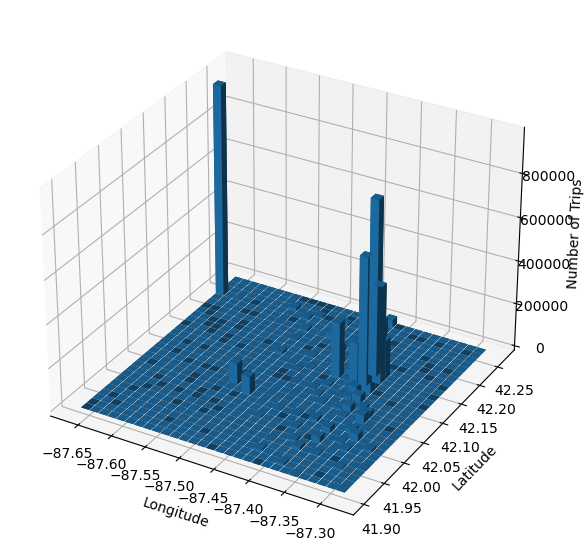

In [142]:
plot_3d_hist(ct_p.toPandas())

Видим, что самая плотная точка посадки находится на северо-западе (41.899602111|-87.633308037|673'556). Очевидно - это аэропорт О'Хара. 
Другие плотные точки находятся в центре города.  
Посмотрим график для точек с количеством поездок менее 70К

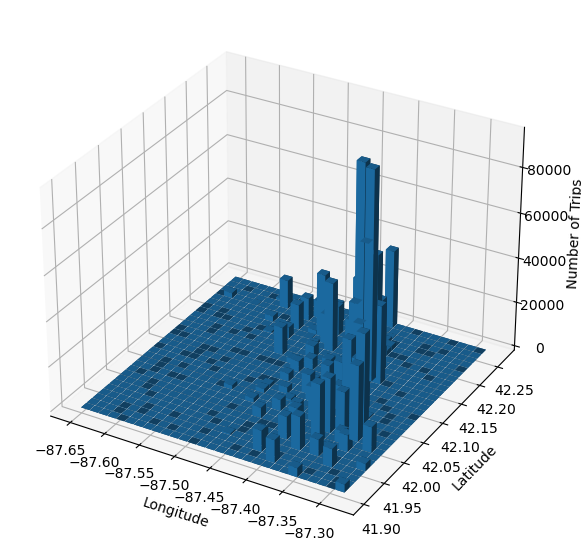

In [143]:
plot_3d_hist(ct_p.filter(f.col("count")<70000).toPandas())

Наиболее плотные области также в центре - вдоль озера.  
Посмотрим на точки высадки

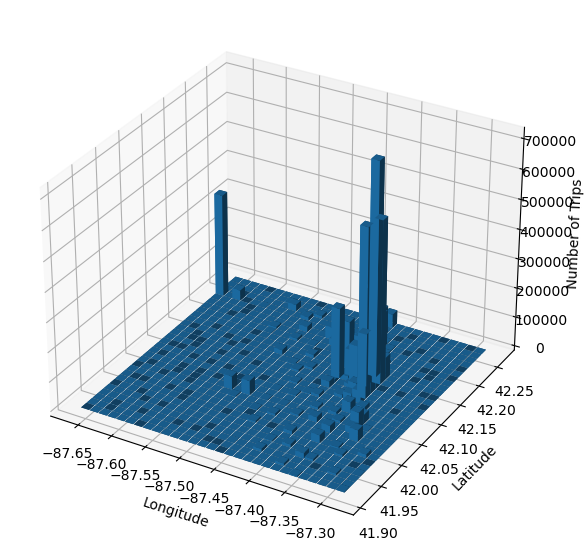

In [144]:
plot_3d_hist(ct_d.toPandas())

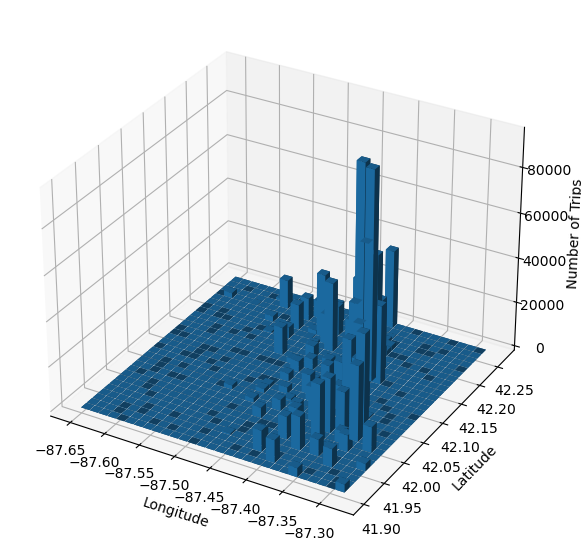

In [145]:
plot_3d_hist(ct_p.filter(f.col("count")<70000).toPandas())

Плотность точек высадки имеет схожую картину. Но аэропорт не лидирует.  

Основные выводы  
- следует отдельно анализировать поездки из аэропорта (и в аэропорт)
- основная часть поездок совершается по центральным районам